## Loading the libraries and the data

In [39]:
import os
import numpy as np 
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi": 300, "savefig.dpi": 300}) # I like high-res figures 
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
import seaborn as sns
import umap
from matplotlib.lines import Line2D
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cdist, pdist
from scipy.stats import wasserstein_distance
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, accuracy_score
)

In [ ]:
E_base        = np.load("/Users/ali/Downloads/emb_base_5k (1).npy")
E_c9_als_up   = np.load("/Users/ali/Downloads/emb_C9orf72_ALS_up_5k.npy")

#------------------------------------------------------------------------

base               = ad.read_h5ad("adata_base_5k.h5ad")
C9orf72_als_up     = ad.read_h5ad("adata_C9orf72_ALS_up_5k.h5ad")

## 3.1. PCA plot

Let's run a simple PCA plot on the embeddings to see how they stack up against each other. We will have 4 plots in total, with 2 plots (highlighted by `Condition` to make it easier to see cells in the latent space) per category (baseline or pertubration).

Here's what we are plotting:

- Base
- C9orf72 ↑ (up-regulation)

Here's what the code is doing:
- First we normalize the names to "pn" and "als" in the `Condition column` using the `norm_condition_df` function.
- After that, we use custom function to plot PCA plots `pca_highlight_grid` - it basically creates plots together in a grid for multiple conditions, while highlighting each condition separately, because it's difficult to figure out which embeddings come from which cells when they are overlayed. We can 
    - The `panels` argument takes in  list of three things:
        - The names of the plots. 
        - The embeddings
        - And the cell labels
- Next, we basically generate a PCA plot using the embeddings and color them separately twice - once for `ALS` and once for `PN`, for both the base (non-perturbed) and the _C9orf72_ up-regulated state.

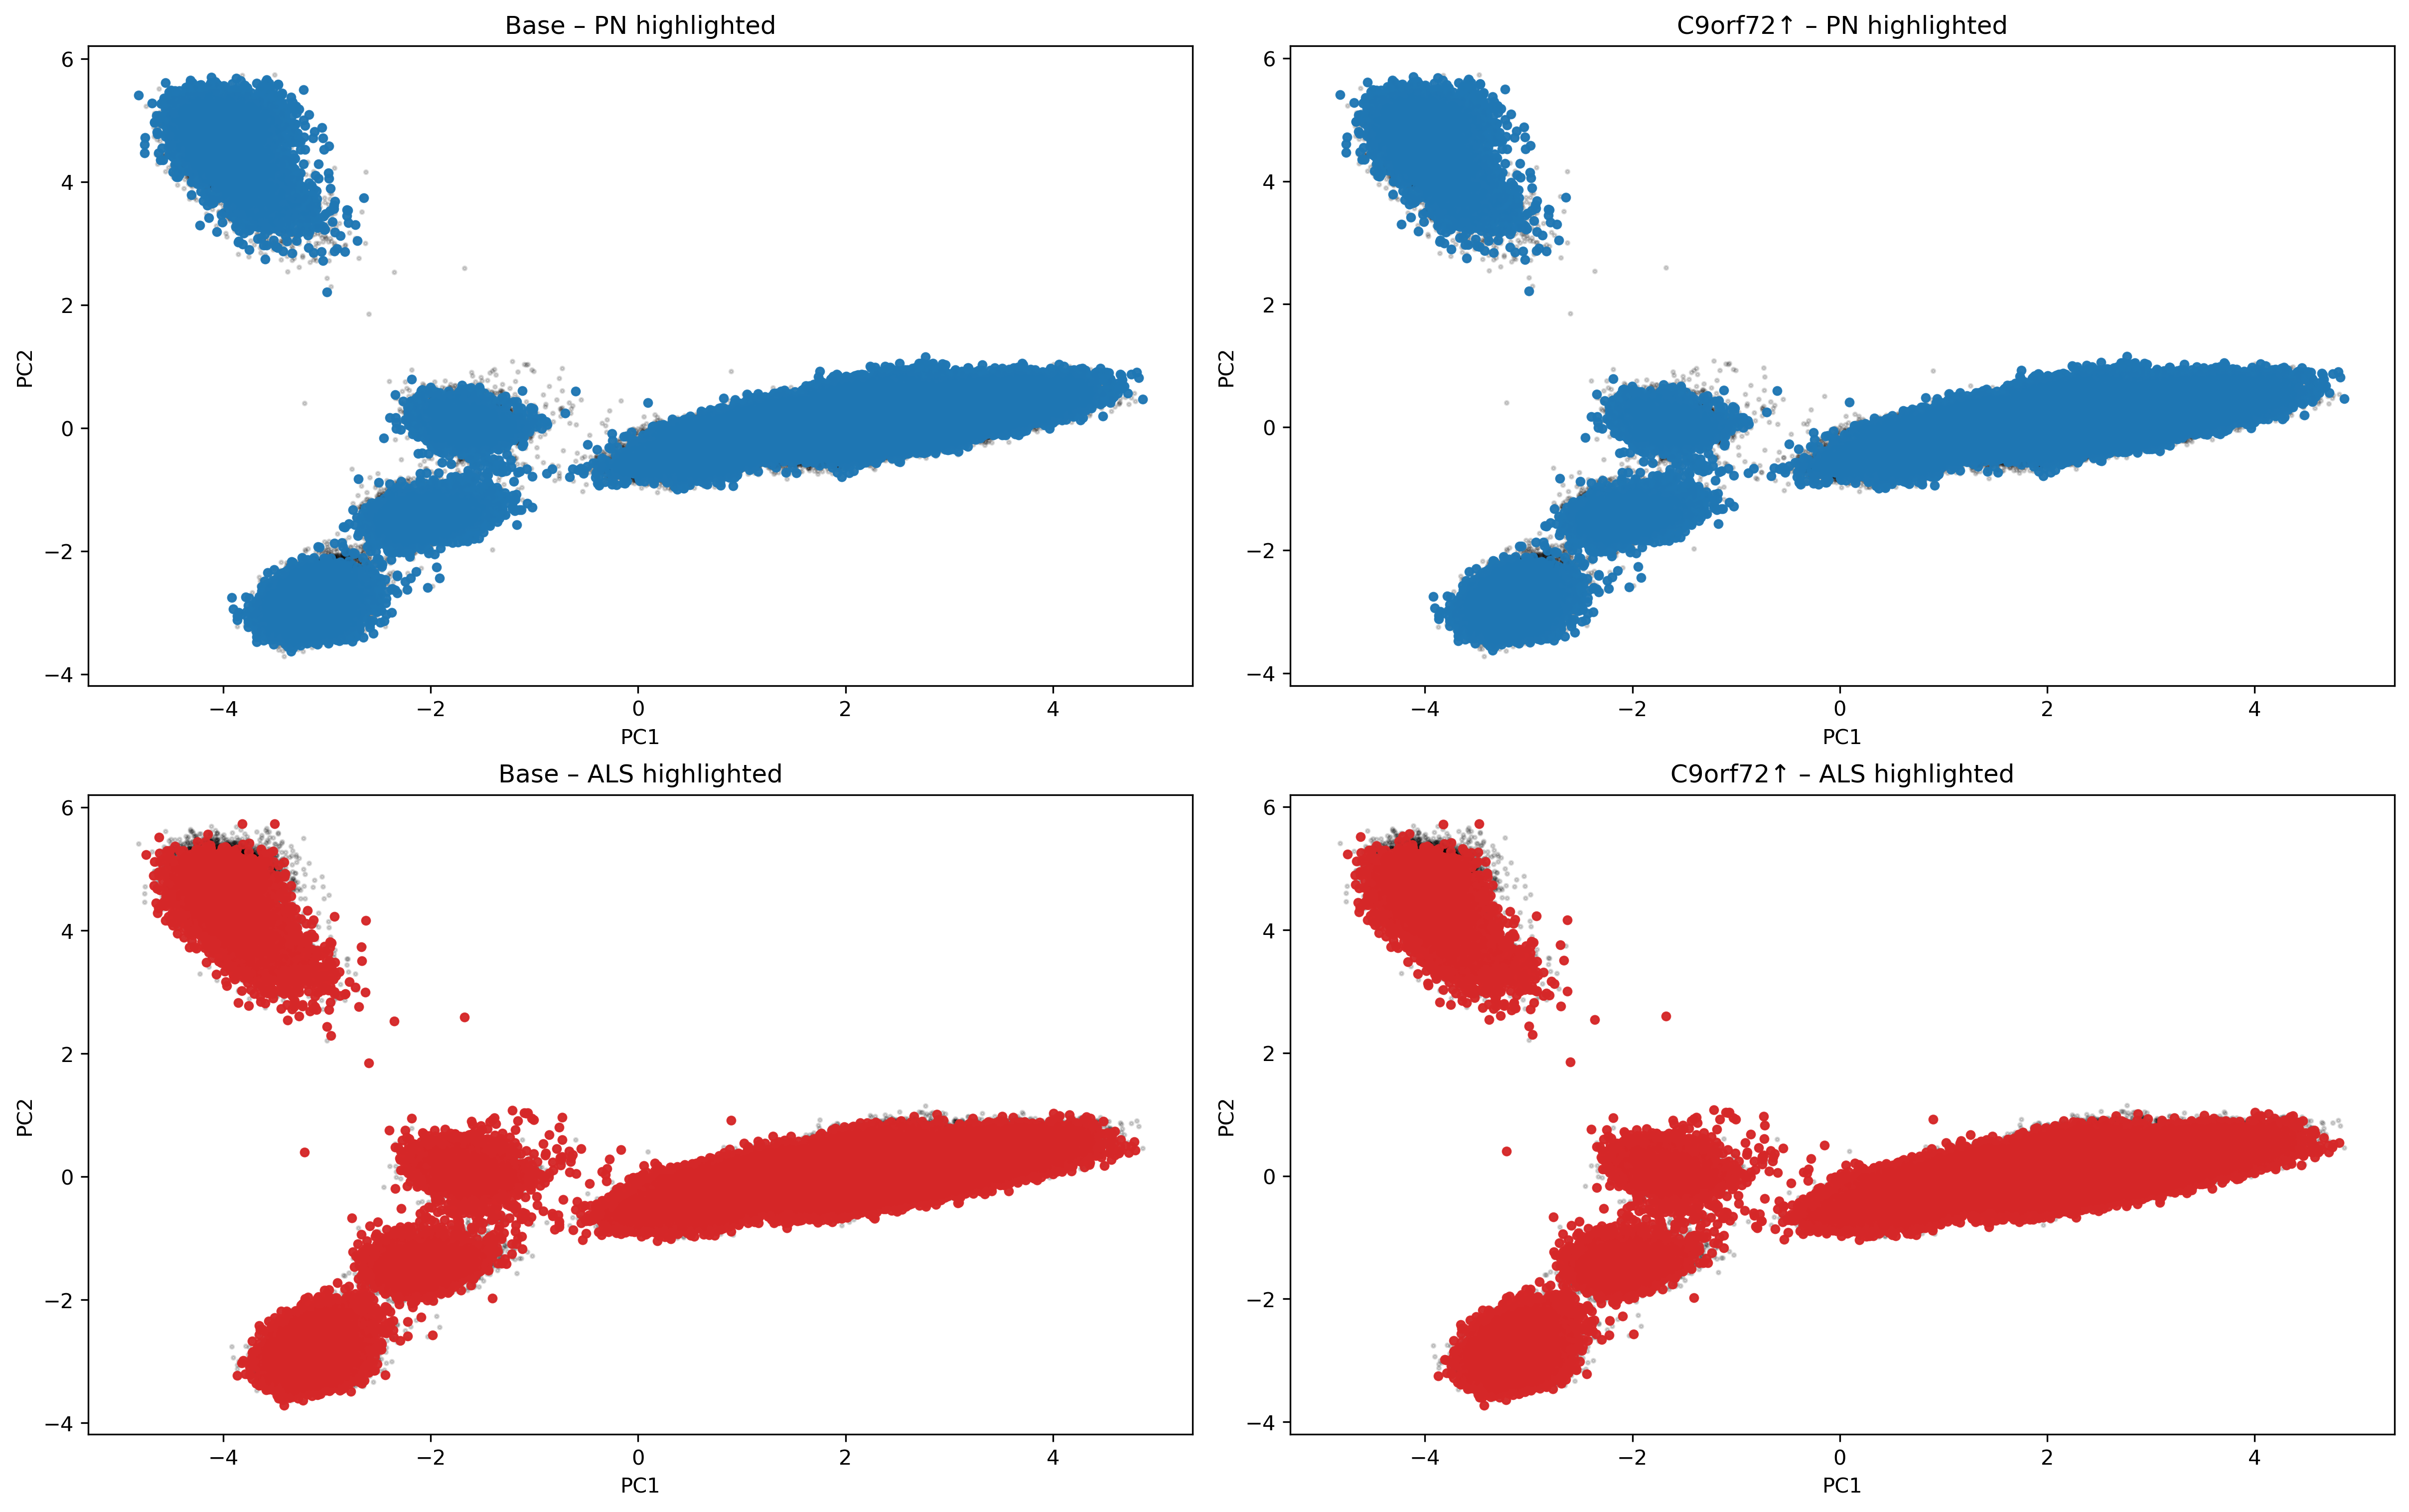

In [20]:
def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np": "pn", "control": "pn"})

def pca_highlight_grid(panels, outfile="pca_base_vs_c9up_2x2.png", rs=0,
                       figsize_per_panel=(7, 10),  # width per column, total height
                       dpi=600,
                       s_bg=4, s_hi=12):
    """
    panels = [(name, E, labels_series), ...]
    Creates a 2 x N grid: top row PN highlighted, bottom row ALS highlighted.
    """
    n = len(panels)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(2, n, figsize=(fig_w, fig_h), constrained_layout=True)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, (name, E, lab) in enumerate(panels):
        if E.shape[0] != len(lab):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != labels length ({len(lab)})")

        P = PCA(n_components=2, random_state=rs).fit_transform(E)
        m_als = (lab.values == "als")
        m_pn  = (lab.values == "pn")

        # Top row: PN highlighted
        ax = axes[0, i]
        ax.scatter(P[:,0], P[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(P[m_pn,0], P[m_pn,1], s=s_hi, c="#1f77b4", alpha=0.95, label="PN", rasterized=True)
        ax.set_title(f"{name} – PN highlighted")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

        # Bottom row: ALS highlighted
        ax = axes[1, i]
        ax.scatter(P[:,0], P[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(P[m_als,0], P[m_als,1], s=s_hi, c="#d62728", alpha=0.95, label="ALS", rasterized=True)
        ax.set_title(f"{name} – ALS highlighted")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

    # High-res PNG
    plt.savefig(outfile, dpi=dpi, bbox_inches="tight", facecolor="white")
    # Also save a crisp vector PDF (small size thanks to rasterized background points)
    plt.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight", facecolor="white")
    plt.show()

# --- build labels (your AnnData objects must already be loaded) ---
labels_base  = norm_condition_df(base.obs)
labels_c9_up = norm_condition_df(C9orf72_als_up.obs)

# --- panels: only Base and C9orf72↑ ---
panels = [
    ("Base",      E_base,      labels_base),
    ("C9orf72↑",  E_c9_als_up, labels_c9_up),
]

# --- draw (tweak dpi/size as you like) ---
pca_highlight_grid(
    panels,
    outfile="pca_base_vs_c9up_2x2.png",
    rs=0,
    figsize_per_panel=(8, 10),  # wider columns
    dpi=300,                    # very high resolution
    s_bg=3, s_hi=14             # marker sizes
)

**Figure 1**: On the PCA plot, there doesn't seem to be a drastic visual difference between the baseline and the C9orf72 up-regulation. We can probe it further using the more non-linear UMAPs. 

## 3.2. UMAP

The code for producing UMAPs is pretty much re-used from the PCA plotting so it functionally works exactly the same, except that now we are generating a UMAP instead of running a PCA. So the arguments are essentially the same, but the name of the function differs a little. 

### 3.2.1. UMAP by Condition

In this first UMAP, we are going to plot the embeddings and color them by condition: `ALS` and `PN`. 

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


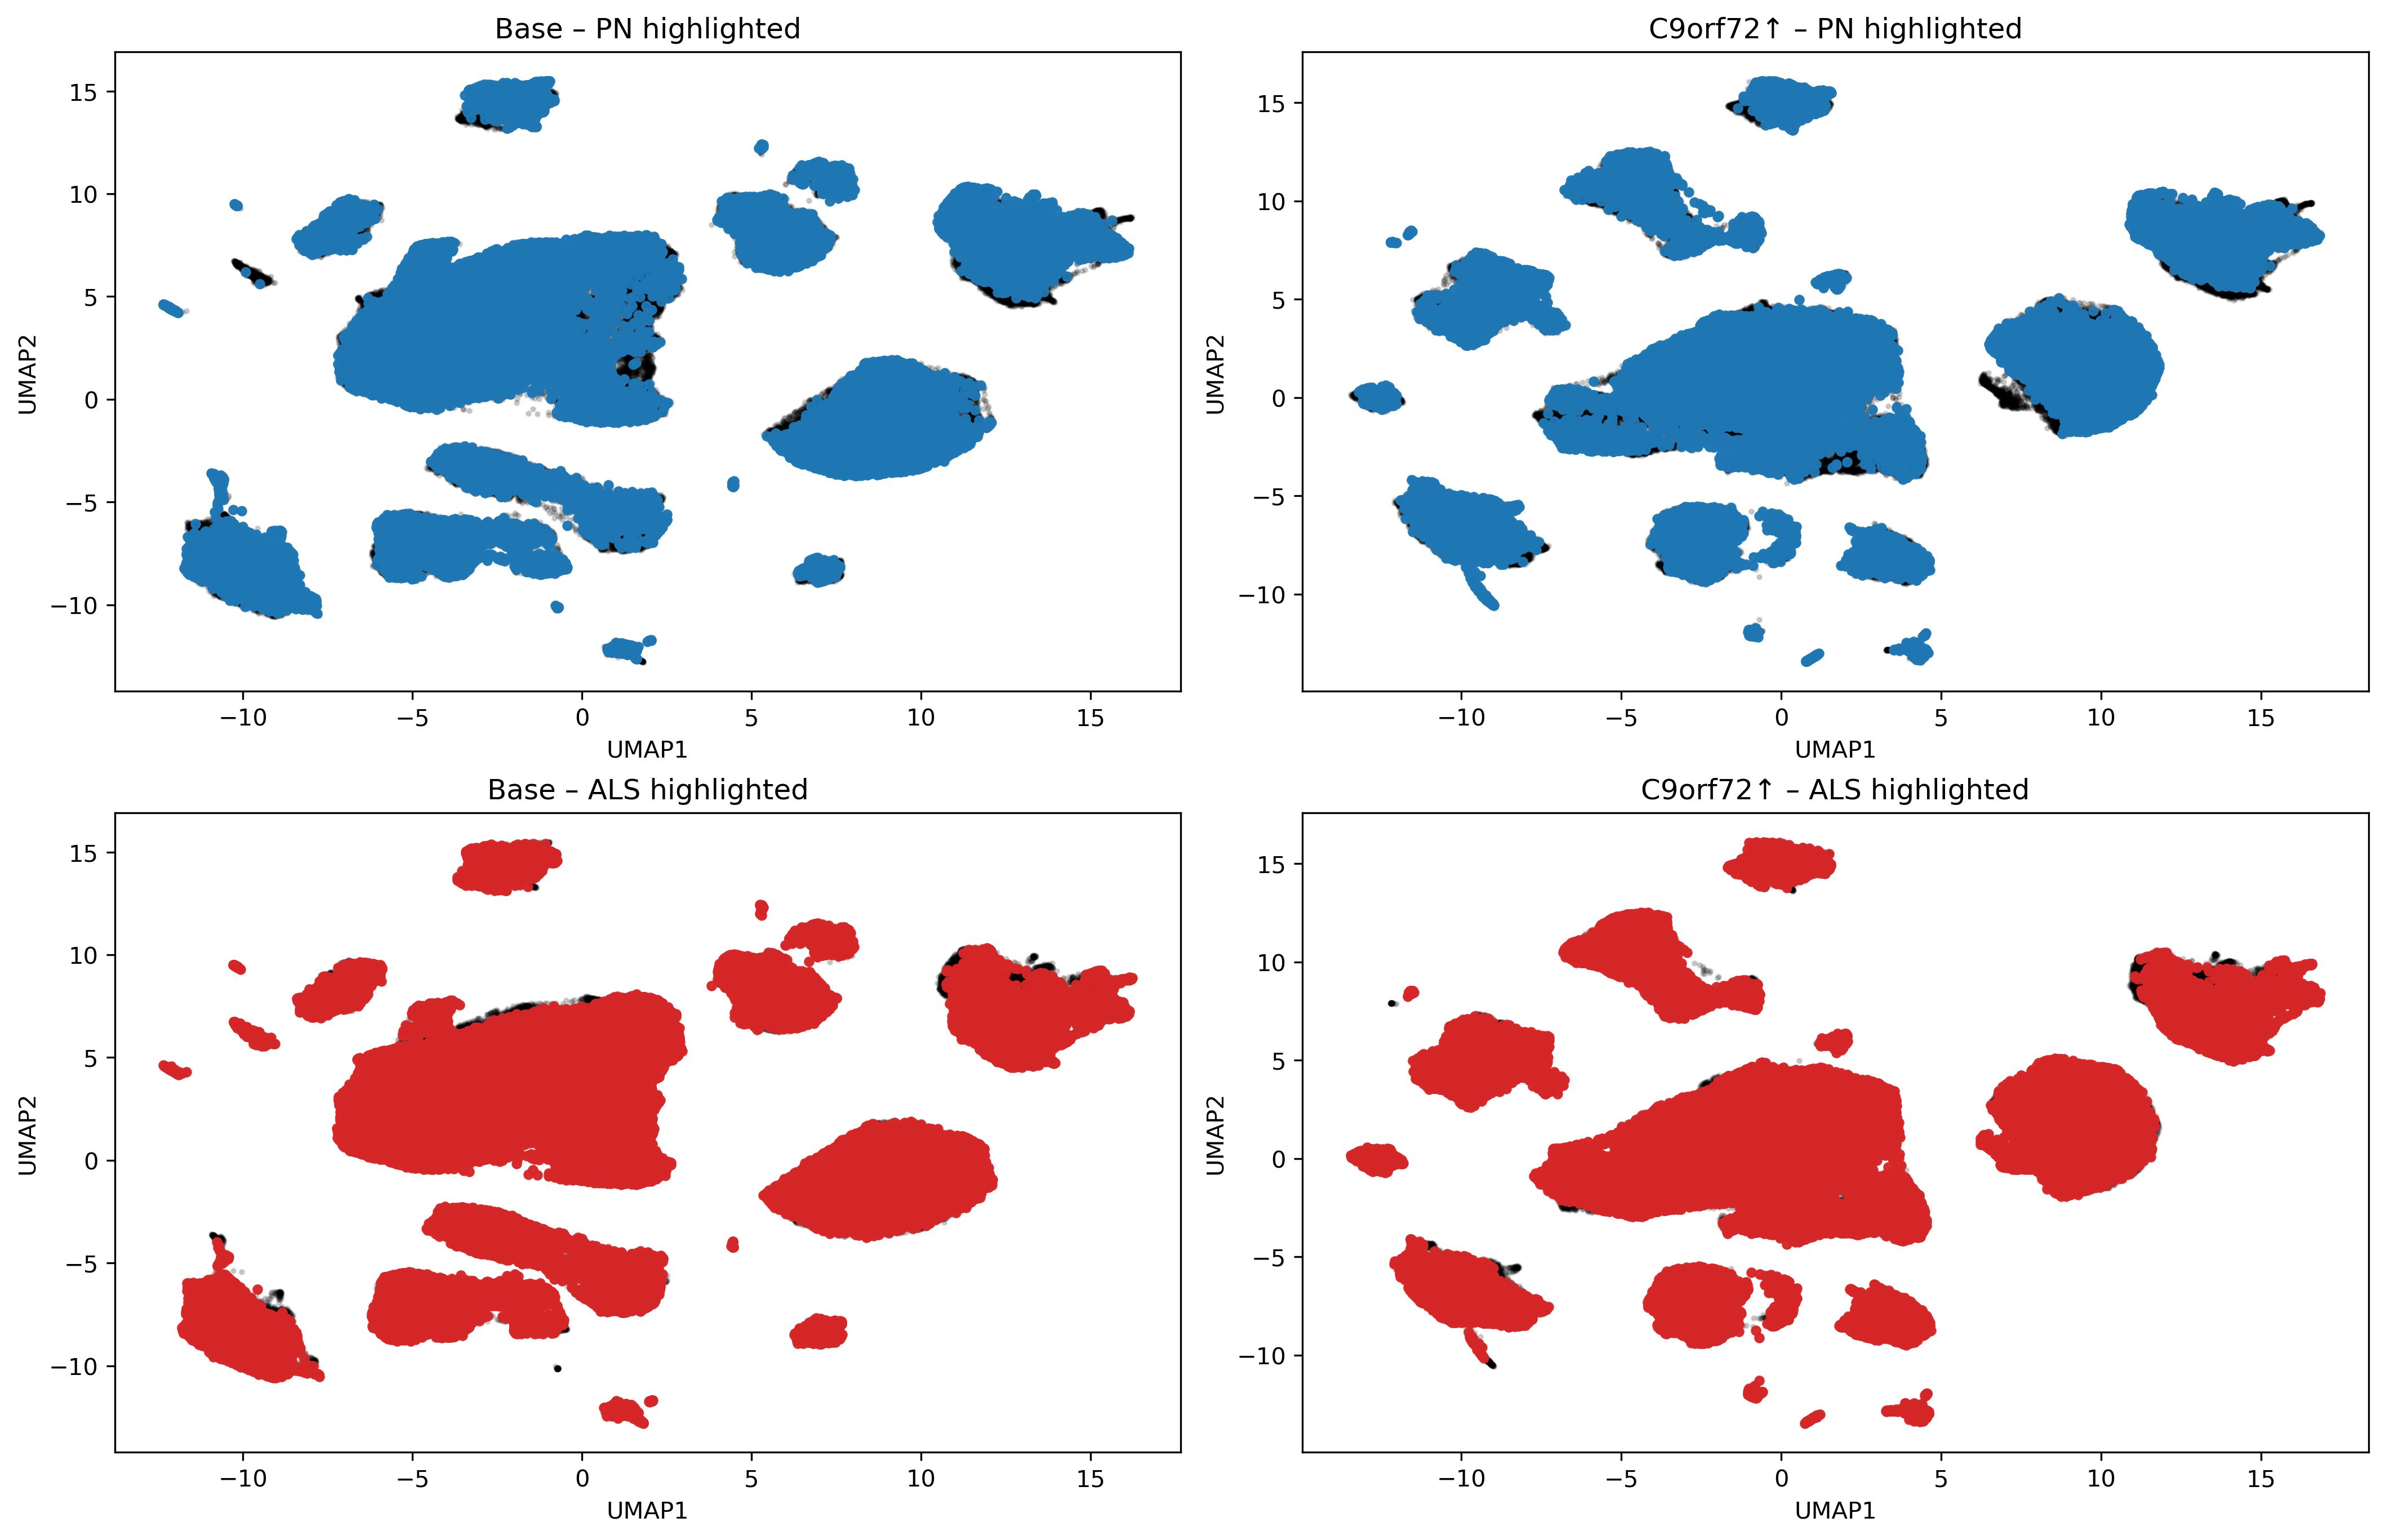

In [21]:
def umap_highlight_grid(
    panels,                          
    outfile="umap_base_vs_c9up_2x2.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(7, 10),       
    s_bg=4,                          
    s_hi=12                          
):
    n = len(panels)
    fig_w = figsize_per_panel[0] * n
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(2, n, figsize=(fig_w, fig_h), constrained_layout=True)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for i, (name, E, lab) in enumerate(panels):
        if E.shape[0] != len(lab):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != labels length ({len(lab)})")

        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=rs)
        U = reducer.fit_transform(E)

        m_als = (lab.values == "als")
        m_pn  = (lab.values == "pn")

        # Top: PN highlighted
        ax = axes[0, i]
        ax.scatter(U[:,0], U[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(U[m_pn,0], U[m_pn,1], s=s_hi, c="#1f77b4", alpha=0.95, label="PN", rasterized=True)
        ax.set_title(f"{name} – PN highlighted")
        ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

        # Bottom: ALS highlighted
        ax = axes[1, i]
        ax.scatter(U[:,0], U[:,1], s=s_bg, c="#000000", alpha=0.15, rasterized=True)
        ax.scatter(U[m_als,0], U[m_als,1], s=s_hi, c="#d62728", alpha=0.95, label="ALS", rasterized=True)
        ax.set_title(f"{name} – ALS highlighted")
        ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

    plt.savefig(outfile, bbox_inches="tight", facecolor="white")
    plt.show()

# ----- Draw (300 DPI) -----
umap_highlight_grid(
    panels,
    outfile="umap_base_vs_c9up_2x2.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize_per_panel=(7, 9),
    s_bg=3,
    s_hi=12
)

**Figure 2A**: For the UMAPs, we can see that there seems to be some difference in the embeddings and their positions in the latent space, in response to the perturbation. This gives us that biological signal that we want to track. However, we need to probe it further to see where the signal is originating from. 

### 3.2.2. UMAP by Cell Types

For this UMAP, we will plot the embeddings and color them by the cell types they belong to. Here's what's going on:

- The `get_celltype_series` function takes the `CellType` column and converts it to string and replaces NAs with "Unknown" cell types - a little sanity check that also handles missing values. 
- The `build_type_palette` function essentially assigns a unique color to each cell type so that we can visualize them distinctly. 
- And the `umap_celltype_grid_two` is basically the UMAP plotting function from above with additional modifications to account for coloring by cell types.

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


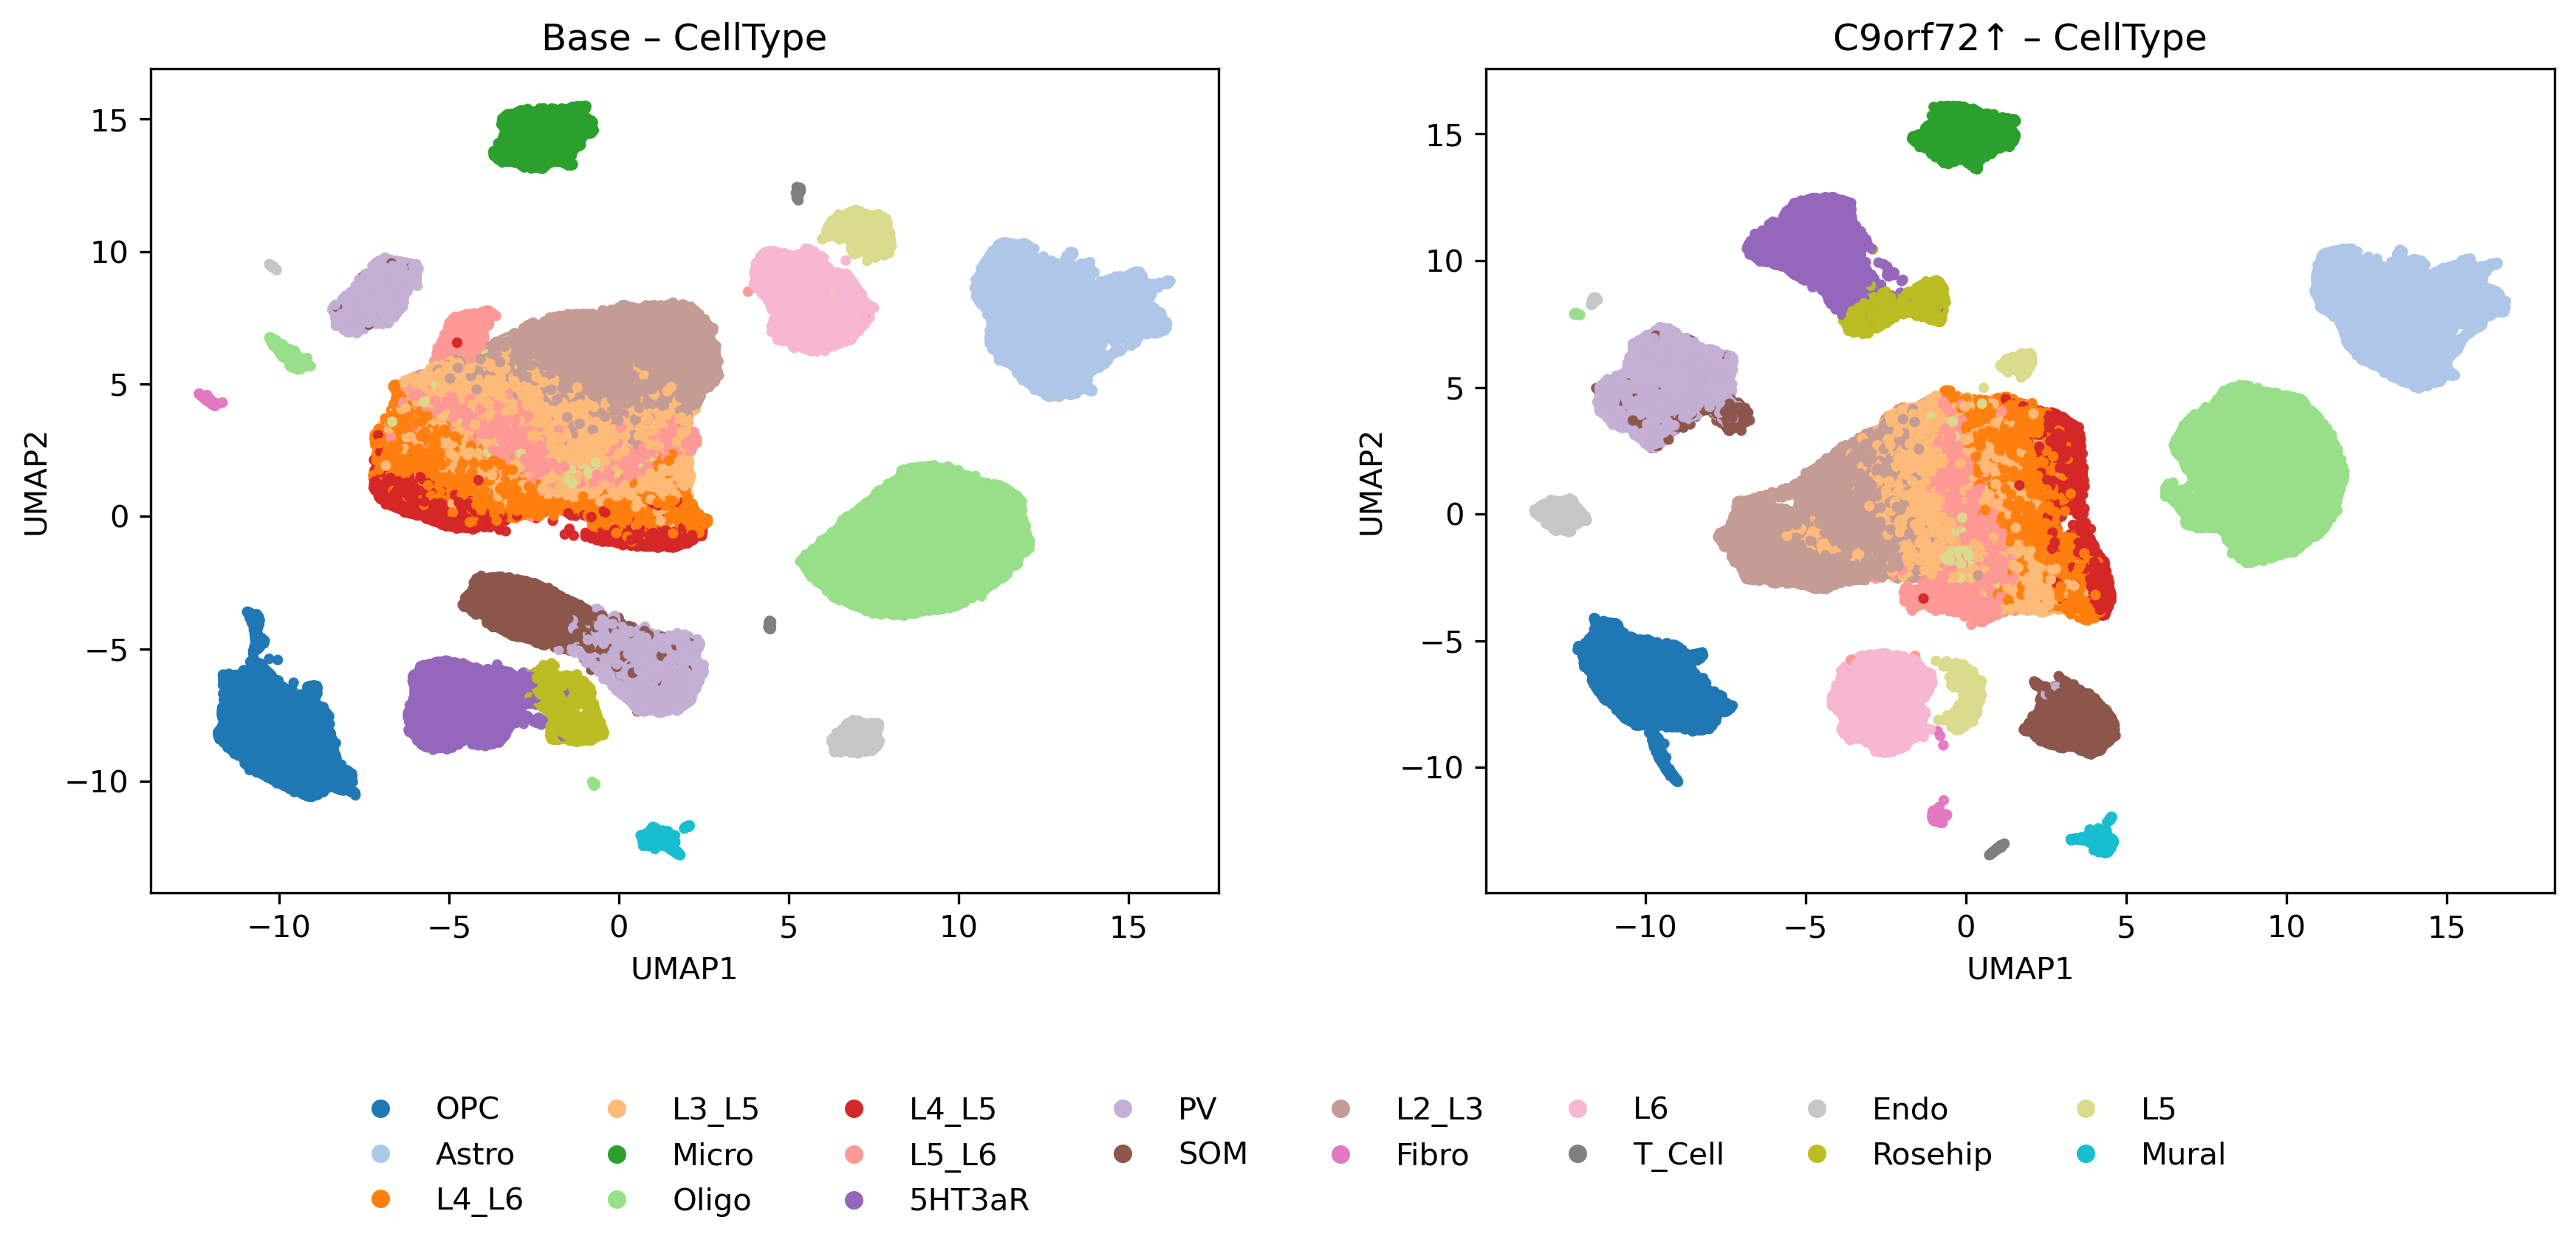

In [22]:
# --- helpers ---
def get_celltype_series(obs):
    for k in ["CellType"]:
        if k in obs.columns:
            return obs[k].astype(str).fillna("Unknown")
    raise KeyError("No CellType column found (tried: CellType).")

def build_type_palette(all_types):
    """Create a stable color for each unique cell type."""
    # Concatenate some categorical colormaps to cover many types
    cmaps = [plt.colormaps.get_cmap("tab20"),
             plt.colormaps.get_cmap("tab20b"),
             plt.colormaps.get_cmap("tab20c")]
    colors = []
    # Pull colors in round-robin fashion from these maps
    i = 0
    while len(colors) < len(all_types):
        cmap = cmaps[i % len(cmaps)]
        # tab20* maps have 20 discrete colors at indices 0..19
        for j in range(cmap.N):
            colors.append(cmap(j))
            if len(colors) >= len(all_types):
                break
        i += 1
    return {t: colors[k] for k, t in enumerate(all_types)}

def umap_celltype_grid_two(
    panels,                 # [(name, E, AnnData), (name, E, AnnData)]
    outfile="umap_celltype_grid_base_vs_c9up.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize=(14, 6),
    s=6
):
    if len(panels) != 2:
        raise ValueError("This helper expects exactly two panels.")

    # Build cell-type series for both panels
    cts_list = [get_celltype_series(a.obs) for _, _, a in panels]
    # Sanity: lengths must match embeddings
    for (name, E, _), ct in zip(panels, cts_list):
        if E.shape[0] != len(ct):
            raise ValueError(f"{name}: embeddings rows ({E.shape[0]}) != celltype length ({len(ct)})")

    # Union of all types for a consistent palette
    all_types = pd.unique(pd.concat(cts_list, ignore_index=True))
    type_to_color = build_type_palette(all_types)

    # Fit UMAP per panel (seeded for reproducibility)
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=False)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for ax, (name, E, a), ct in zip(axes, panels, cts_list):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=rs)
        U = reducer.fit_transform(E)

        # Map colors per cell
        colors = [type_to_color.get(t, (0.5, 0.5, 0.5, 0.7)) for t in ct.values]
        ax.scatter(U[:, 0], U[:, 1], s=s, c=colors, alpha=0.95, rasterized=True)
        ax.set_title(f"{name} – CellType")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")

    # Build a compact legend below the plots
    handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=6,
                      markerfacecolor=type_to_color[t], markeredgecolor="none", label=t)
               for t in all_types]
    # Leave space at bottom for legend
    fig.subplots_adjust(bottom=0.26, wspace=0.25)
    fig.legend(handles=handles,
               loc="lower center",
               ncol=min(8, len(handles)),
               frameon=False)

    plt.savefig(outfile, bbox_inches="tight", facecolor="white")
    plt.show()

panels_two = [
    ("Base",      E_base,      base),
    ("C9orf72↑",  E_c9_als_up, C9orf72_als_up),
]

umap_celltype_grid_two(
    panels_two,
    outfile="umap_celltype_grid_base_vs_c9up.png",
    n_neighbors=15,
    min_dist=0.3,
    rs=0,
    figsize=(14, 6),
    s=6
)

**Figure 2B**: We can qualitatively see that there are certain diffferences between the base and the perturbed data. Let's summarize them below:
- The `L2_L3` cluster seems to be a little distorted in the perturbed dataset, compared to the base. 
- The `PV-SOM` cluster seems to break away into a separate `SOM` cluster in the perturbed dataset. 

Besides these two changes, the rest are hard to qualitatively analyze. So we will move to more quantitative methods to analyze these datasets. 

## 3.3. Clustering

In this part, we will try some unsupervised clustering to see how the embeddings group together and if there are any insights that we can pull from that. 

### 3.3.1. Elbow and Silhouette Plots

To determine a good number of K-clusters to use, I ran an elbow plot and a silhouette plot. Additionally, I calculated the distance between a cell and it's 15th nearest neighbor just to see if how the global neighborhoods look like between the two figures, and see if there's some sort of neighborhood distortment in response to the perturbations. 

- The `knn_distance_elbow` basically fits a NN model using euclidean distance - we can control the number of neighbors by using `n_neighbors`, and we can also subset the data for speed by using a `sample_size` argument.
- The `cluster_elbow_metrics` function essentially fits a KMeans model with different values of _k_ to find the best one. And we also save the inertia and the silhouette scores that we get from this model to evaluate the different values of _k_ at the end. 

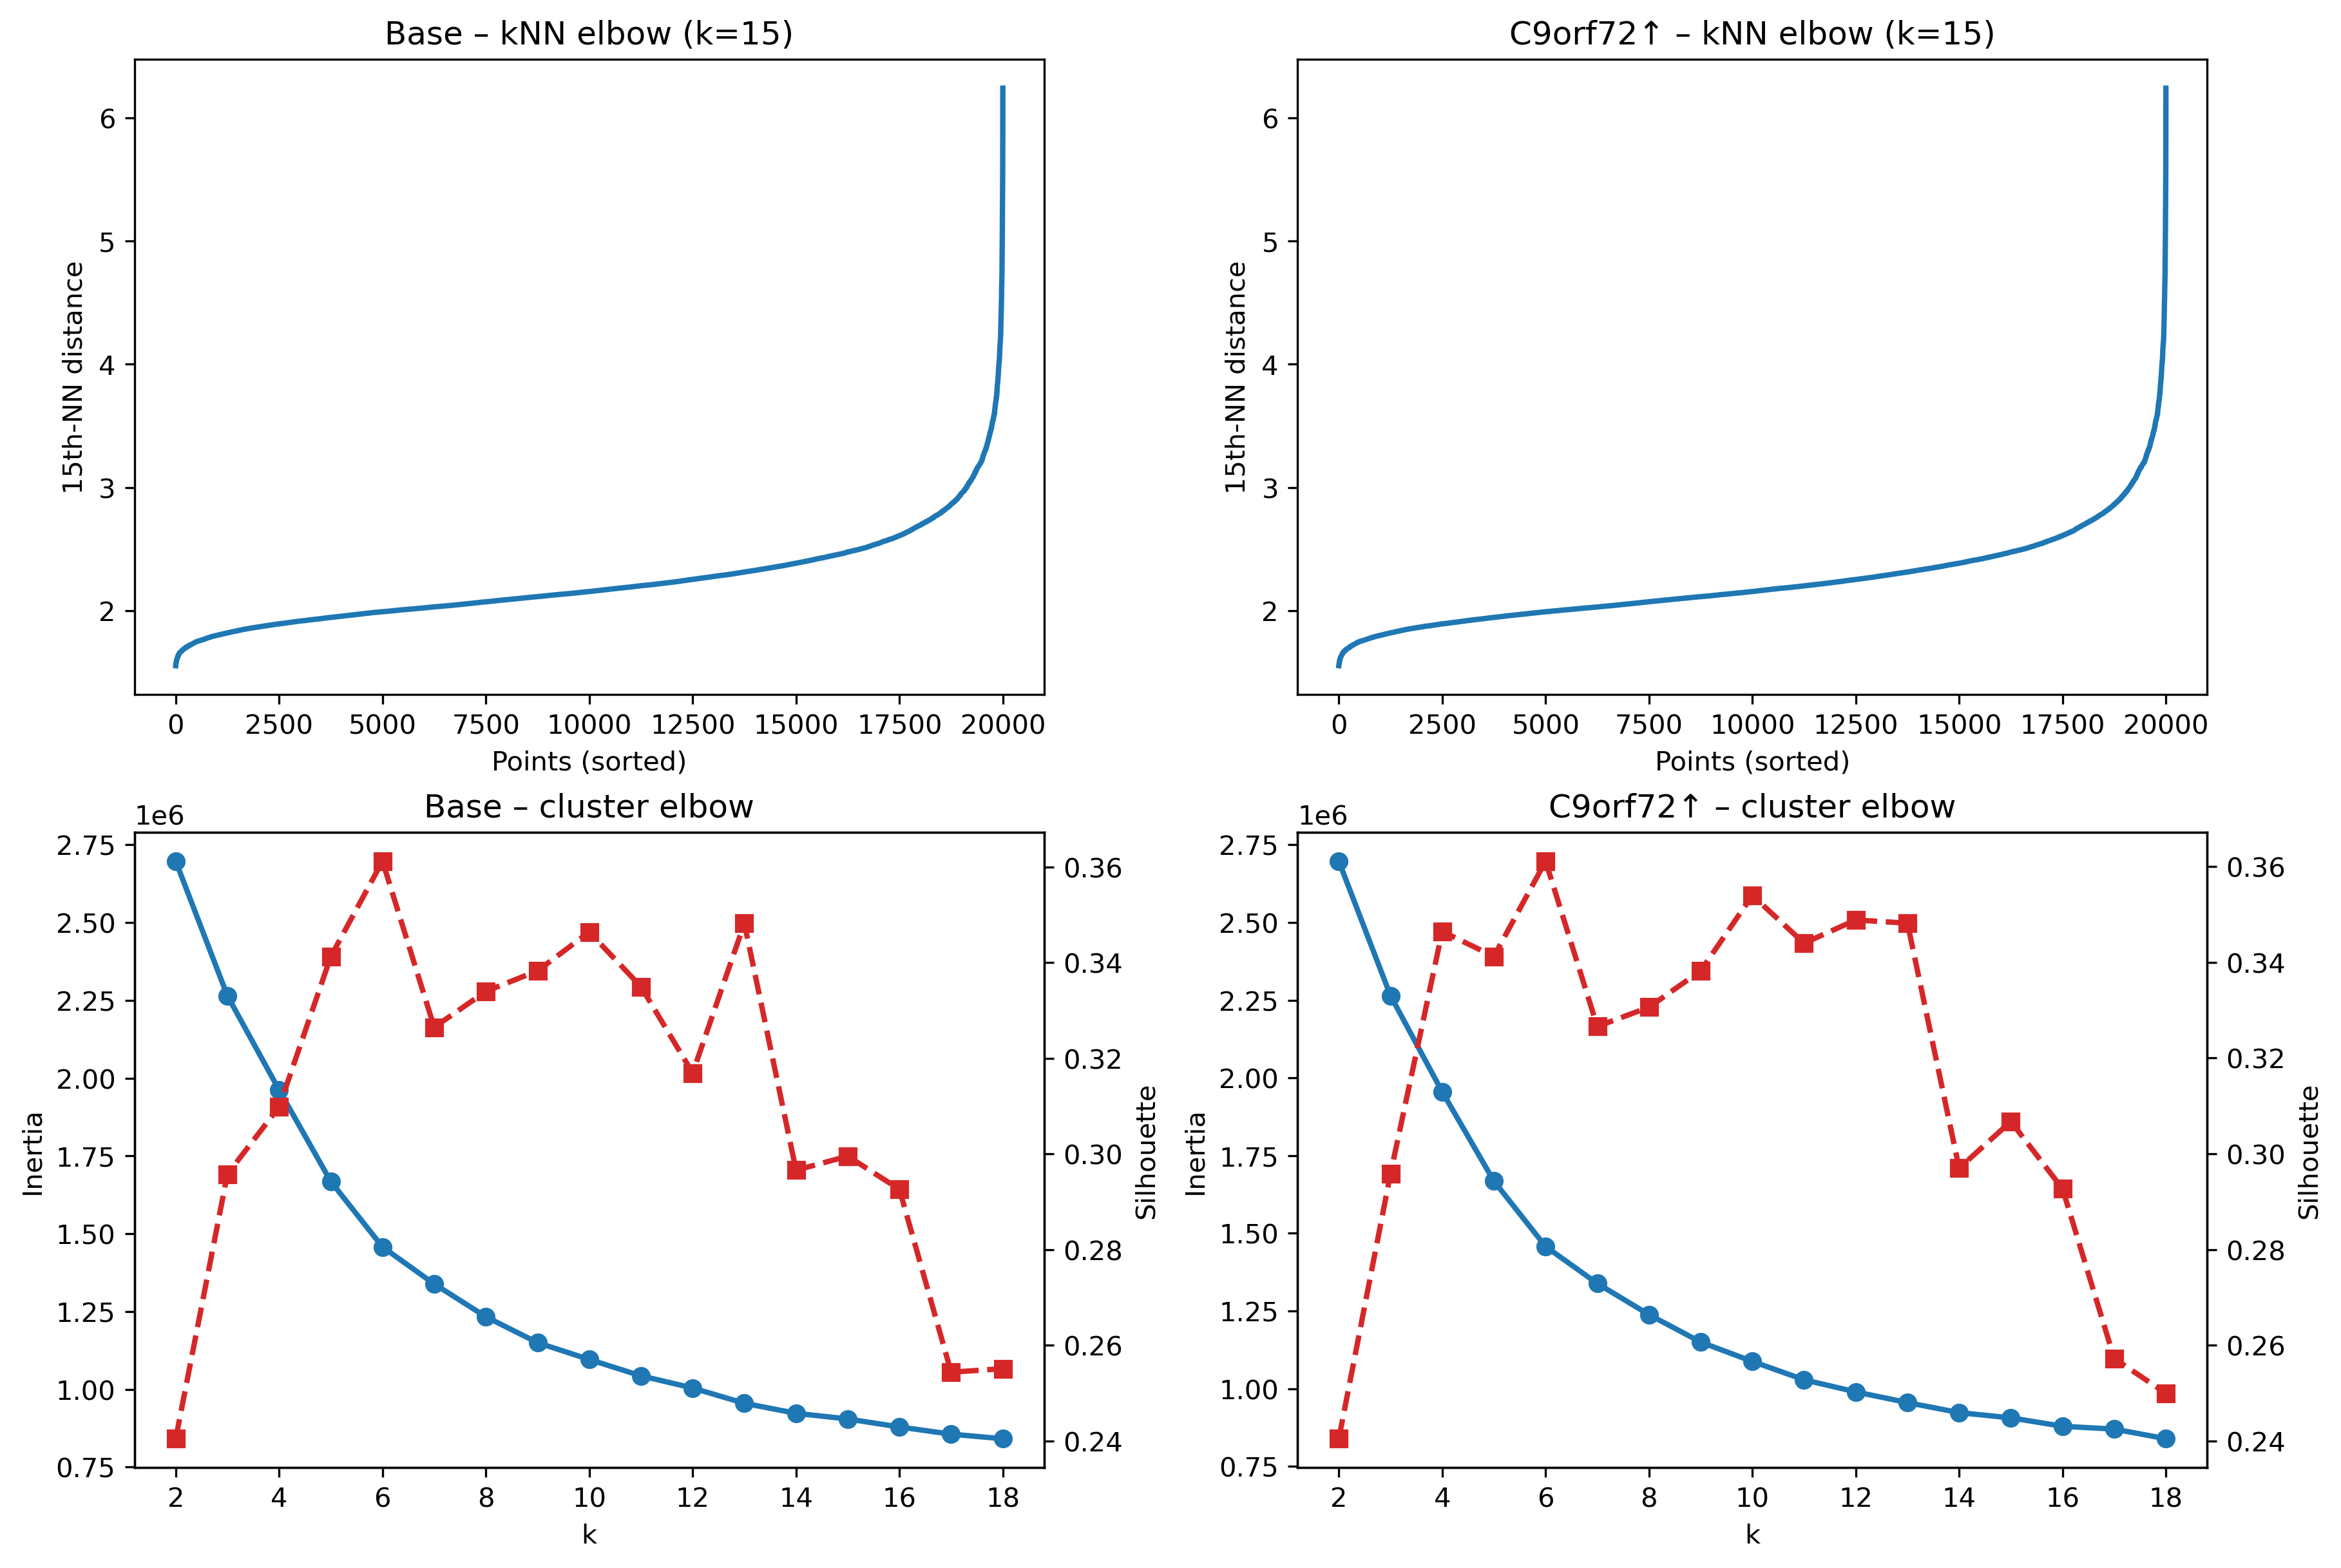

In [33]:
ks = np.arange(2, 19) #There are 20 cell types in total

names  = ["Base", "C9orf72↑"]
embeds = [E_base,  E_c9_als_up]

def knn_distance_elbow(X, n_neighbors=15, sample_size=20000, rs=0):
    rng = np.random.default_rng(rs)
    if X.shape[0] > sample_size:
        idx = rng.choice(X.shape[0], size=sample_size, replace=False)
        X_use = X[idx]
    else:
        X_use = X
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X_use)
    dists, _ = nn.kneighbors(X_use)
    kth = dists[:, n_neighbors-1]
    return np.sort(kth)

def cluster_elbow_metrics(X, ks=range(2, 20), sample_size_sil=3000, rs=0):
    rng = np.random.default_rng(rs)
    inertias, sils = [], []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=rs).fit(X)
        inertias.append(km.inertia_)
        if X.shape[0] > sample_size_sil:
            idx = rng.choice(X.shape[0], size=sample_size_sil, replace=False)
            sil = silhouette_score(X[idx], km.predict(X[idx]), metric="euclidean")
        else:
            sil = silhouette_score(X, km.labels_, metric="euclidean")
        sils.append(sil)
    return np.array(inertias), np.array(sils)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

for i, (name, E) in enumerate(zip(names, embeds)):
    elbow = knn_distance_elbow(E, n_neighbors=15, sample_size=20000, rs=0)
    ax = axes[0, i]
    ax.plot(np.arange(len(elbow)), elbow, lw=2)
    ax.set_title(f"{name} – kNN elbow (k=15)")
    ax.set_xlabel("Points (sorted)")
    ax.set_ylabel("15th-NN distance")

for i, (name, E) in enumerate(zip(names, embeds)):
    inertias, sils = cluster_elbow_metrics(E, ks, sample_size_sil=3000, rs=0)
    ax1 = axes[1, i]
    ax2 = ax1.twinx()
    ax1.plot(ks, inertias, marker="o", lw=2, label="Inertia")
    ax2.plot(ks, sils, marker="s", lw=2, ls="--", color="#d62728", label="Silhouette")
    ax1.set_title(f"{name} – cluster elbow")
    ax1.set_xlabel("k")
    ax1.set_ylabel("Inertia")
    ax2.set_ylabel("Silhouette")

plt.savefig("elbows_base_vs_c9up.png", dpi=300, bbox_inches="tight")
plt.show()

**Figure 3A**: Based on the neighborhood analysis (top row), we can see that the distance between the neighbors is pretty much the same, and the global organization does not differ too much between the base and the perturbed state. Additionally, based on the inertia elbow and the silhouette peak, we can see that the optimal number for `k` is 6 for both experiments. 

### 3.3.2. KMeans Clustering using K = 6

Having figured out the best `k` from our silhouette plot above, we will now proceed to run a KMeans model using the selected `k` and then plot a UMAP colored by clusters to see how the clusters distribute in different conditions. Here's what I am doing in this code chunk:

- Running a KMeans model using the best `k` that we got. 
- Visualize the clusters using a UMAP.
- Find out if the proportions of ALS vs PN cells differs by cluster using a Chi-squared test. 

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


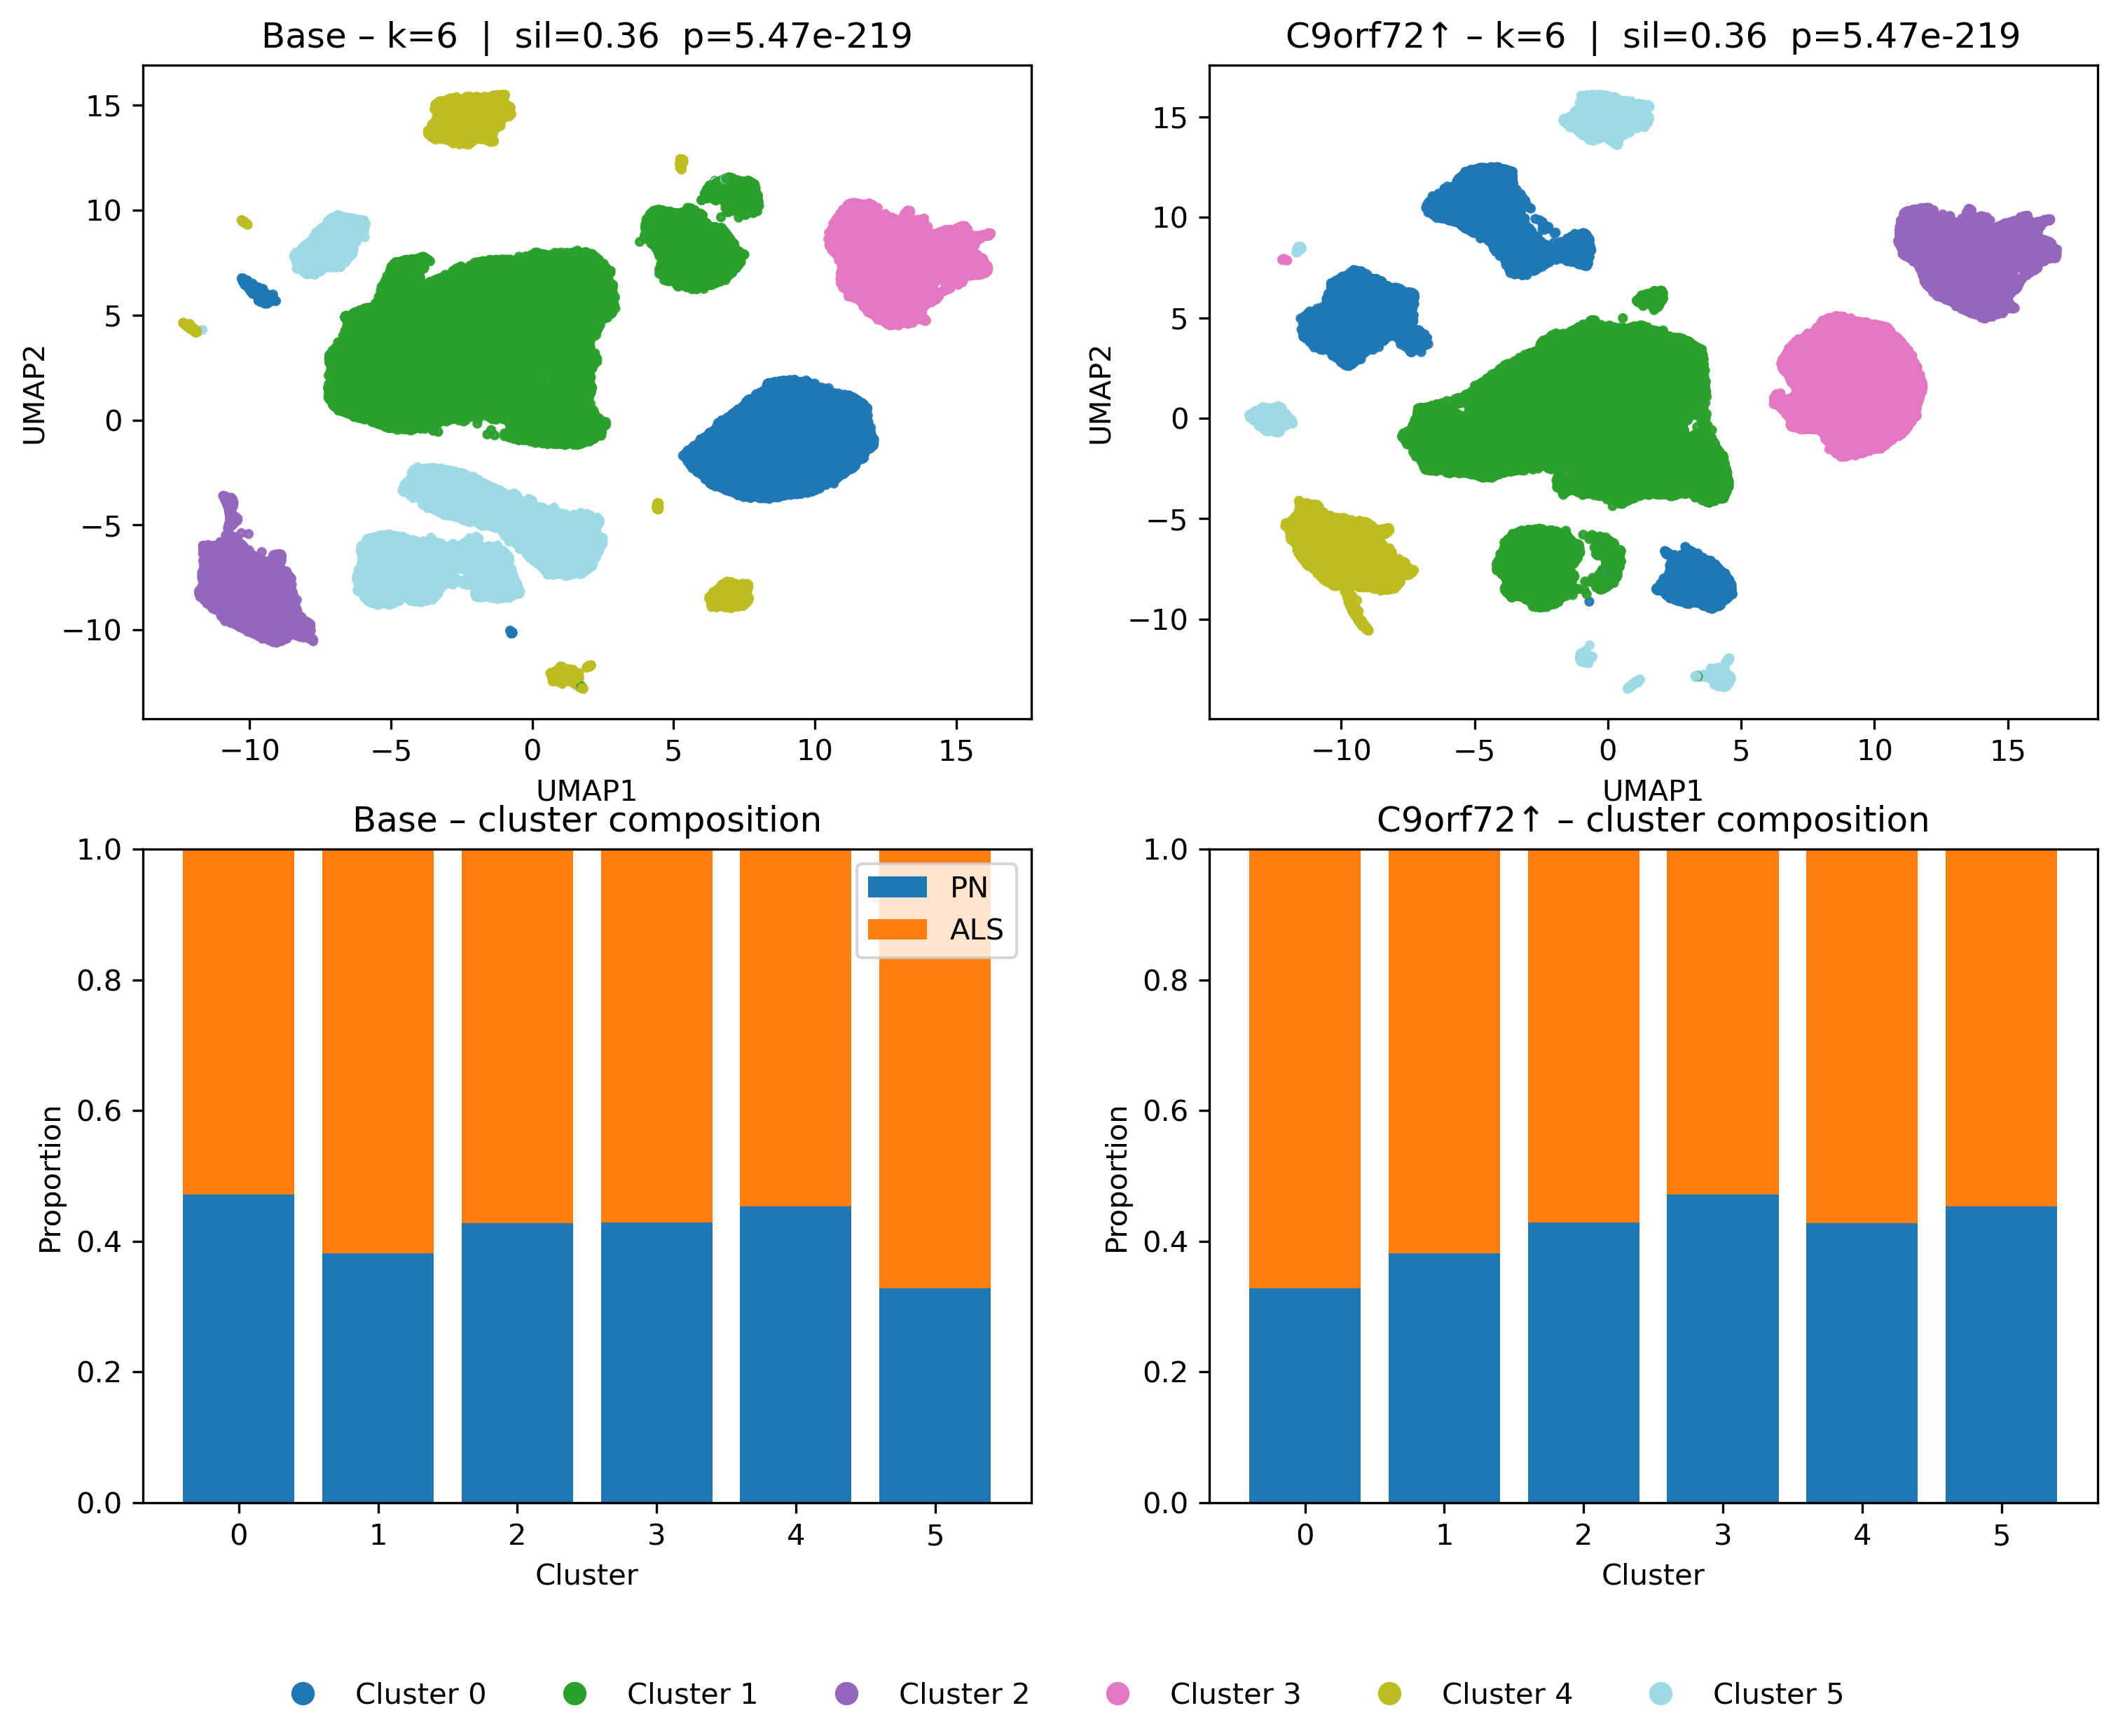

In [31]:
k = 6
names  = ["Base","C9orf72↑"]
embeds = [E_base, E_c9_als_up]
adatas = [base,  C9orf72_als_up]
conds  = [norm_condition_df(a.obs) for a in adatas]

results = []
for name, E, a, c in zip(names, embeds, adatas, conds):
    # KMeans clustering
    km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(E)
    lab = km.labels_.astype(int)
    a.obs["k6"] = pd.Categorical(lab)  # in-memory only

    # UMAP embedding
    U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)

    # Clustering quality
    sil = silhouette_score(E, lab, metric="euclidean")

    # PN vs ALS composition per cluster
    tab = pd.crosstab(a.obs["k6"], c)
    for col in ["als","pn"]:
        if col not in tab.columns:
            tab[col] = 0
    tab = tab[["pn","als"]].sort_index()

    chi2, p, dof, exp = chi2_contingency(tab.values) if tab.values.sum() > 0 else (np.nan, np.nan, np.nan, None)
    prop = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    # Optional CSVs (comment out if you don’t want files)
    tab.to_csv(f"{name}_k6_cluster_condition_counts.csv")
    prop.to_csv(f"{name}_k6_cluster_condition_props.csv")

    results.append((name, U, lab, prop, sil, p))

# ----- Plot: 2 rows x 2 columns -----
cmap = plt.colormaps.get_cmap("tab20")
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=False)

# Top row: UMAP colored by cluster labels
for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[0, i]
    ax.scatter(U[:,0], U[:,1], c=lab, s=6, cmap=cmap, vmin=0, vmax=k-1, alpha=0.9, rasterized=True)
    ax.set_title(f"{name} – k={k}  |  sil={sil:.2f}  p={p:.2e}")
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

# Bottom row: stacked PN/ALS proportions per cluster
for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[1, i]
    x = np.arange(prop.shape[0])
    ax.bar(x, prop["pn"].values, label="PN")
    ax.bar(x, prop["als"].values, bottom=prop["pn"].values, label="ALS")
    ax.set_xticks(x)
    ax.set_xticklabels([str(k_) for k_ in range(prop.shape[0])])
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cluster"); ax.set_ylabel("Proportion")
    ax.set_title(f"{name} – cluster composition")
    if i == 0:
        ax.legend()

# Shared cluster legend at the bottom
handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=8,
                  markerfacecolor=cmap(i/(k-1)), markeredgecolor="none", label=f"Cluster {i}")
           for i in range(k)]
fig.subplots_adjust(bottom=0.12, top=0.88)
fig.legend(handles=handles, loc="lower center", ncol=k, frameon=False)

plt.savefig("k6_umap_clusters_and_compositions_base_vs_c9up.png",
            dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

**Figure 3B**: This figure shows us that the between different clusters, the proportions of `ALS` to `PN` cells is significantly different. Hence, it suggests that some cell types are disproportionately affected by `ALS`.

## 3.4. Neighborhood Analysis

We are using mean as the centroids because they minimize the sum squared distances in Euclidean geometry. 

- `fisher_ratio`: We calculate Fisher's ratio to find out if the groups got better clustered after perturbation (uses the principles of linear discriminant analysis to maximize between class variance and minimize within class variance). In our case we see that the difference in Fisher ratio is marginally positve. This can be interpreted as the groups `ALS` and `PN` moving further apart, which is a bad thing for the perturbation if the driving force is the between centroids difference, or netural if the driving force is the shrinkage of within-class scatter, which doesn't necessarily inform our perturbation technique. I did not delve into this deeper because the difference was very small.
    - Base Fisher ratio: 0.012013
    - C9orf72↑ Fisher ratio: 0.012114
    - Difference: 0.000101 
- `neighbor_label_fraction`: Here I am calculating what fraction of an ALS cell's neighborhood (15 cells) is PN cells. If the difference in the proportions was positive after perturbation, that would suggest that ALS cells mix more with PN cells which likely means that the prturbation is taking us towards a healthier cell state. However, since the difference is negative it means that `ALS` cells are getting more exclusive and that our perturbation likely did not work the way we wanted, at least on the basis of this simplistic analysis.
    - Base PN proportion: 0.169433 
    - C9orf72↑ PN proprortion: 0.169289
    - Difference: -0.000144
- `median_projection_along_base_axis`: This function was a pretty simple way to check if the `ALS` cells moved towards `PN` cells. All I did was calculate a vector between the centroids of `ALS` and `PN` cells in the base data. And then I projected (dot product) the difference in the embeddings of the perturbation and the base onto that ALS-PN vector. A positive value should mean that we are moving towards `PN`. However, since we got a value of 0, it suggests that the `ALS` cells barely moved towards `PN`, if any. 



In [ ]:
def align_on_obs(base_adata, pert_adata, E_base, E_pert):
    """Align rows by shared obs_names; return matched embeddings and the base obs rows."""
    common = base_adata.obs_names.intersection(pert_adata.obs_names)
    bi = base_adata.obs_names.get_indexer(common)
    pi = pert_adata.obs_names.get_indexer(common)
    return E_base[bi], E_pert[pi], base_adata.obs.loc[common]

def centroid(X):
    return np.nanmean(X, axis=0)

def fisher_ratio(E, labels):
    m_als = labels.values == "als"
    m_pn  = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als = centroid(E[m_als]); c_pn = centroid(E[m_pn])
    between = np.linalg.norm(c_als - c_pn)**2
    s_als = np.mean(np.sum((E[m_als] - c_als)**2, axis=1))
    s_pn  = np.mean(np.sum((E[m_pn]  - c_pn )**2, axis=1))
    within = s_als + s_pn + 1e-12
    return float(between / within)

def neighbor_label_fraction(E, labels, focus="als", target="pn", k=15):
    """Among focus cells, fraction of kNN that are target."""
    m_focus = labels.values == focus
    if not m_focus.any():
        return np.nan
    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(E)
    _, idx = nn.kneighbors(E[m_focus])
    idx = idx[:, 1:]  # drop self
    lab_arr = labels.values
    targ = (lab_arr[idx] == target).mean(axis=1)
    return float(np.mean(targ))

def median_projection_along_base_axis(Eb, Ep, labels):
    """
    Project ALS per-cell displacement (Ep - Eb) onto the Base ALS→PN centroid axis.
    Positive => moving toward PN along that axis.
    """
    m_als = labels.values == "als"; m_pn = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als_b = centroid(Eb[m_als]); c_pn_b = centroid(Eb[m_pn])
    u = c_pn_b - c_als_b
    u = u / (np.linalg.norm(u) + 1e-12)
    disp = Ep - Eb
    proj = disp[m_als] @ u
    return float(np.median(proj))

# ---------- analyze Base vs C9orf72↑ only ----------
name = "C9orf72↑"
Eb_al, Ep_al, obs_b = align_on_obs(base, C9orf72_als_up, E_base, E_c9_als_up)
labs = norm_condition_df(obs_b)

# Metrics
fr_base = fisher_ratio(Eb_al, labs)
fr_pert = fisher_ratio(Ep_al, labs)
fr_delta = fr_pert - fr_base

mix_base = neighbor_label_fraction(Eb_al, labs, focus="als", target="pn", k=15)
mix_pert = neighbor_label_fraction(Ep_al, labs, focus="als", target="pn", k=15)
mix_delta = mix_pert - mix_base if not np.isnan(mix_base) and not np.isnan(mix_pert) else np.nan

med_proj_along_axis = median_projection_along_base_axis(Eb_al, Ep_al, labs)

metrics2 = pd.DataFrame([{
    "group": name,
    "fisher_ratio_base": fr_base,
    "fisher_ratio_pert": fr_pert,
    "fisher_ratio_delta": fr_delta,
    "als_neighbor_pn_frac_base": mix_base,
    "als_neighbor_pn_frac_pert": mix_pert,
    "als_neighbor_pn_frac_delta": mix_delta,
    "median_proj_ALS_along_base_axis": med_proj_along_axis,
}])

metrics2.to_csv("extra_embedding_change_metrics_base_vs_c9up.csv", index=False)
print(metrics2)

      group  fisher_ratio_base  fisher_ratio_pert  fisher_ratio_delta  \
0  C9orf72↑           0.012013           0.012114            0.000101   

   als_neighbor_pn_frac_base  als_neighbor_pn_frac_pert  \
0                   0.169433                   0.169289   

   als_neighbor_pn_frac_delta  sliced_wasserstein  energy_distance  \
0                   -0.000144            0.000298         0.000014   

   median_proj_ALS_along_base_axis  
0                              0.0  


## 3.5. Simple MLP to Predict Condition from Embeddings

### 3.5.1. Helper Functions

This was perhaps not required, but I thought a great way to determine whether our perturbations had any effect would be to build a model that learns which embeddings come from `ALS` cells and which ones come from `PN` cells. I got this idea when I saw that there was a `split` column in the `.obs` and it had `test` and `train` split already defined. So I figured that this would be a great use of a pre-defined split. Therefore, I built a simple multi-layer perceptron (MLP) and trained it to predict `ALS` or `PN` based on the embeddings. 

Here's what the custom functions are doing:

- `pick_condition_series`: finds the `Condition` column and normalized PN. 
- `ensure_split_series`: gets use the split type (train or test)
- `align_on_common_obs`: just a little quality check to ensure that all the cells are aligned in the same order across the datasets and the embeddings. 
- `make_weighted_sampler`: sampling based on the proportions of the ALS and PN cells. 
- `plot_confmat`: simple function to plot a confusion matrix. 
- `best_threshold`: function for calculating the area under the ROC. 
- `infer_probs`: converts logits to probabilities

In [65]:
# -------------- Helpers --------------
def pick_condition_series(obs_df):
    # normalize Condition/condition to "als"/"pn"
    if "Condition" in obs_df.columns:
        s = obs_df["Condition"].astype(str)
    elif "condition" in obs_df.columns:
        s = obs_df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found in base.obs")
    s = s.str.strip().str.lower().replace({"np": "pn", "control": "pn"})
    return s

def ensure_split_series(obs_df):
    if "split" not in obs_df.columns:
        raise KeyError("base.obs['split'] not found (expected 'train'/'test').")
    s = obs_df["split"].astype(str).str.strip().str.lower()
    return s

def align_on_common_obs(base_ad, pert_ad, E_base, E_pert, subset_index=None):
    """
    Align rows by shared obs_names; if subset_index is given (positional indices into base),
    restrict to those base rows first. Returns:
      Eb_aligned, Ep_aligned, common_names (Index), base_pos_idx (np.ndarray of ints)
    """
    if subset_index is not None:
        base_subset_names = base_ad.obs_names[subset_index]
        common = base_subset_names.intersection(pert_ad.obs_names)
    else:
        common = base_ad.obs_names.intersection(pert_ad.obs_names)
    if len(common) == 0:
        raise ValueError("No overlapping cells between base and pert for the given subset.")
    b_idx = base_ad.obs_names.get_indexer(common)
    p_idx = pert_ad.obs_names.get_indexer(common)
    return E_base[b_idx], E_pert[p_idx], common, b_idx

def make_weighted_sampler(y_int):
    class_counts = np.bincount(y_int, minlength=2)
    class_counts = np.maximum(class_counts, 1)
    weights = 1.0 / class_counts
    sample_weights = weights[y_int]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

def plot_confmat(cm, labels, title, outfile=None):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_xticklabels(labels)
    ax.set_yticks([0,1]); ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(int(cm[i, j])), ha="center", va="center",
                    color=("white" if cm[i, j] > cm.max()/2 else "black"), fontsize=10)
    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")
    plt.show()

def train_with_scheduler(
    model, train_dl, val_X_t, val_y_np, pos_weight, device,
    base_lr=1e-3, weight_decay=1e-4, epochs=40, patience=8
):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    optim = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

    steps_per_epoch = max(len(train_dl), 1)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optim, max_lr=base_lr, steps_per_epoch=steps_per_epoch, epochs=epochs
    )

    best_state, best_auroc, wait = None, -np.inf, 0
    sigmoid = nn.Sigmoid()

    def eval_auroc(X_t, y_true_np):
        model.eval()
        probs = []
        with torch.no_grad():
            for i in range(0, X_t.shape[0], 2048):
                xb = X_t[i:i+2048].to(device)
                logits = model(xb)
                probs.append(sigmoid(logits).cpu().numpy())
        probs = np.concatenate(probs)
        if len(np.unique(y_true_np)) < 2:
            return np.nan, probs
        return roc_auc_score(y_true_np, probs), probs

    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device); yb = yb.to(device)
            optim.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            sched.step()
            running += loss.item() * xb.size(0)

        val_auroc, _ = eval_auroc(val_X_t, val_y_np)
        print(f"Epoch {epoch:03d} | train_loss {running/len(train_dl.dataset):.4f} | val_AUROC {val_auroc:.4f}")

        improved = np.isfinite(val_auroc) and (val_auroc > best_auroc + 1e-4)
        if improved:
            best_auroc = val_auroc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping on AUROC.")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model

def best_threshold(y_true, y_prob, metric="youden"):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    if metric == "youden":
        j = tpr - fpr
        return float(thr[np.argmax(j)])
    return 0.5

def infer_probs(model, X_np, device):
    model.eval()
    X_t = torch.from_numpy(X_np).float().to(device)
    probs = []
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for i in range(0, X_t.shape[0], 2048):
            xb = X_t[i:i+2048]
            logits = model(xb)
            probs.append(sigmoid(logits).cpu().numpy())
    return np.concatenate(probs)

def get_celltype_series(obs, keys=("CellType","Celltype","cell_type","CellClass")):
    for k in keys:
        if k in obs.columns:
            return obs[k].astype(str).fillna("Unknown"), k
    raise KeyError(f"No cell-type column found (tried: {', '.join(keys)})")

def ci95(x):
    return np.percentile(x, [2.5, 97.5])

This is a simple MLP, with the following architecture:
- 3 hidden layers
- Batch normalization on every hidden layer
- 20% Dropout by default
- Relu activation function

In [58]:
class MLP_GELU_BN(nn.Module):
    def __init__(self, d_in, hidden=(256, 128, 64), p_drop=0.2):
        super().__init__()
        self.in_norm = nn.LayerNorm(d_in)
        self.fc1 = nn.Linear(d_in, hidden[0]); self.bn1 = nn.BatchNorm1d(hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1]); self.bn2 = nn.BatchNorm1d(hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2]); self.bn3 = nn.BatchNorm1d(hidden[2])
        self.out = nn.Linear(hidden[2], 1)
        self.drop = nn.Dropout(p_drop)

        for m in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.in_norm(x)
        x = self.drop(F.gelu(self.bn1(self.fc1(x))))
        x = self.drop(F.gelu(self.bn2(self.fc2(x))))
        x = self.drop(F.gelu(self.bn3(self.fc3(x))))
        return self.out(x).squeeze(1)  # logits

Device: mps
Train class balance: pos=36001 neg=23091  → pos_weight=0.641
Epoch 001 | train_loss 0.6503 | val_AUROC 0.5952
Epoch 002 | train_loss 0.5925 | val_AUROC 0.7017
Epoch 003 | train_loss 0.5565 | val_AUROC 0.7634
Epoch 004 | train_loss 0.5185 | val_AUROC 0.8024
Epoch 005 | train_loss 0.4922 | val_AUROC 0.8308
Epoch 006 | train_loss 0.4587 | val_AUROC 0.8536
Epoch 007 | train_loss 0.4278 | val_AUROC 0.8731
Epoch 008 | train_loss 0.3976 | val_AUROC 0.8892
Epoch 009 | train_loss 0.3733 | val_AUROC 0.9044
Epoch 010 | train_loss 0.3453 | val_AUROC 0.9172
Epoch 011 | train_loss 0.3224 | val_AUROC 0.9274
Epoch 012 | train_loss 0.3016 | val_AUROC 0.9343
Epoch 013 | train_loss 0.2853 | val_AUROC 0.9409
Epoch 014 | train_loss 0.2715 | val_AUROC 0.9459
Epoch 015 | train_loss 0.2581 | val_AUROC 0.9500
Epoch 016 | train_loss 0.2485 | val_AUROC 0.9535
Epoch 017 | train_loss 0.2407 | val_AUROC 0.9567
Epoch 018 | train_loss 0.2314 | val_AUROC 0.9592
Epoch 019 | train_loss 0.2211 | val_AUROC 0.9

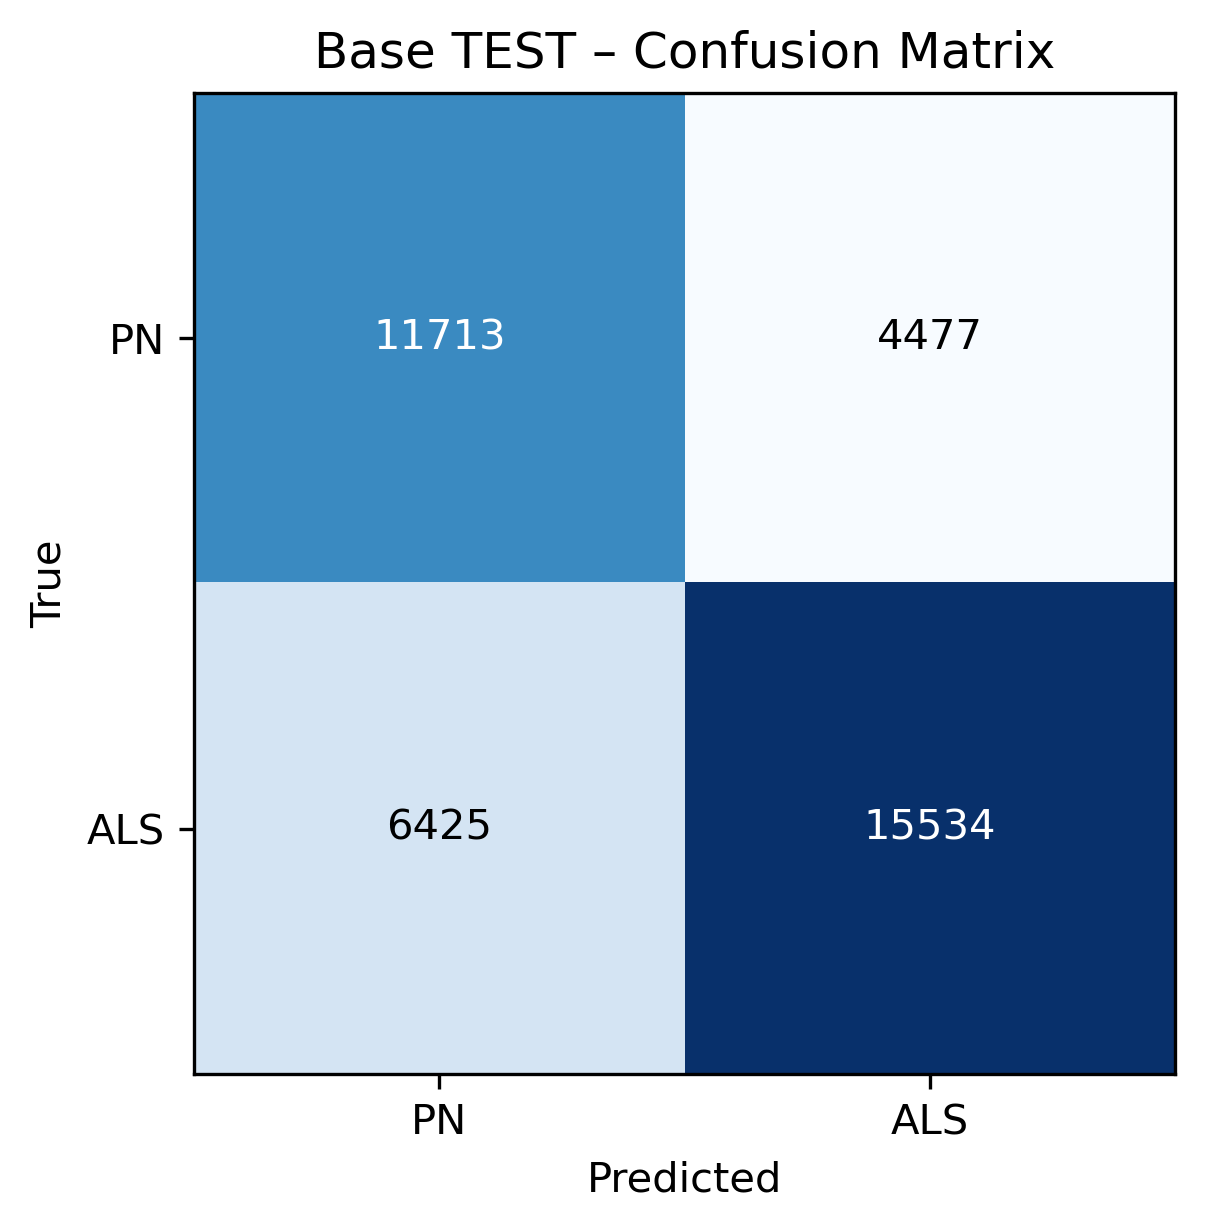


=== TEST (common cells) – C9↑ embeddings ===
Accuracy: 0.7134 | AUROC: 0.7936
Confusion matrix [PN=0, ALS=1]:
 [[11713  4477]
 [ 6455 15504]]


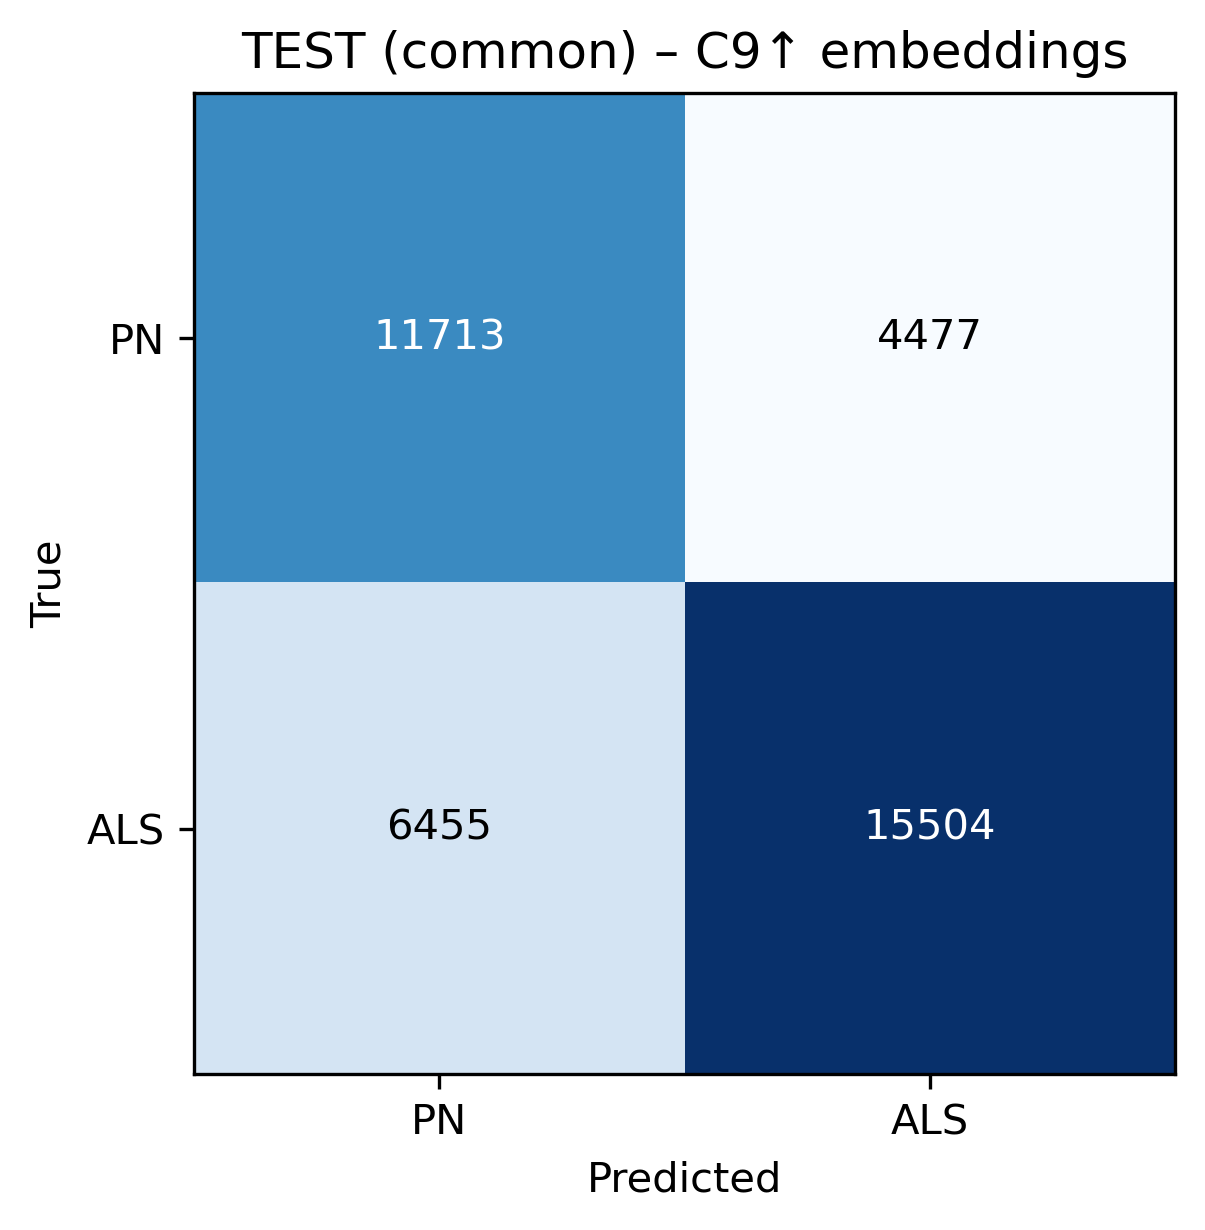

In [59]:
# Device (Apple GPU)
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- Build labels & splits directly from base (do NOT slice E_base) ----
cond_series_full  = pick_condition_series(base.obs)   # "als"/"pn"
split_series_full = ensure_split_series(base.obs)     # "train"/"test"

# Keep only PN/ALS rows
valid_mask_full = cond_series_full.isin(["pn", "als"])

# y labels: PN=0, ALS=1 (numpy array in base.obs order)
y_all_full = (cond_series_full.values == "als").astype(np.int64)

# Train/Test indices from base.obs["split"] (+ valid)
idx_train_full = (split_series_full.values == "train") & valid_mask_full.values
idx_test_full  = (split_series_full.values == "test")  & valid_mask_full.values

# Build matrices straight from E_base (NO scaling; NO L2)
X_train_full = E_base[idx_train_full, :]
y_train_full = y_all_full[idx_train_full]
X_test_base  = E_base[idx_test_full, :]
y_test       = y_all_full[idx_test_full]  # ground truth for Base test

# Stratified split of train → train/val (e.g., 80/20)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=0, stratify=y_train_full
)

# ---- DataLoaders with weighted sampling (to balance classes) ----
X_tr_t = torch.from_numpy(X_tr).float()
y_tr_t = torch.from_numpy(y_tr.astype(np.float32))
train_ds = TensorDataset(X_tr_t, y_tr_t)
sampler = make_weighted_sampler(y_tr.astype(int))
train_dl = DataLoader(train_ds, batch_size=256, sampler=sampler, drop_last=False)

val_X_t = torch.from_numpy(X_val).float()

# ---- Model / Training ----
d_in = X_tr.shape[1]
model = MLP_GELU_BN(d_in, hidden=(256,128,64), p_drop=0.2)

# pos_weight = #neg/#pos on TRAIN only
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
pos_weight = torch.tensor([ (neg / max(pos,1)) ], dtype=torch.float32)  # shape [1]
print(f"Train class balance: pos={pos} neg={neg}  → pos_weight={pos_weight.item():.3f}")

model = train_with_scheduler(
    model, train_dl, val_X_t, y_val, pos_weight, device=device,
    base_lr=1e-4, weight_decay=1e-4, epochs=100, patience=8
)

# Threshold tuned on validation (Youden’s J)
val_probs = infer_probs(model, X_val, device)
thr = best_threshold(y_val, val_probs, metric="youden")
print(f"Chosen decision threshold (Youden’s J on val): {thr:.4f}")

# ---- Evaluate on full Base TEST set (all PN+ALS) ----
test_probs_base = infer_probs(model, X_test_base, device)
y_pred_base = (test_probs_base >= thr).astype(int)
acc_base = accuracy_score(y_test, y_pred_base)
auroc_base = roc_auc_score(y_test, test_probs_base) if len(np.unique(y_test))==2 else np.nan
cm_base = confusion_matrix(y_test, y_pred_base, labels=[0,1])

print("\n=== Base TEST (all) ===")
print(f"Accuracy: {acc_base:.4f} | AUROC: {auroc_base:.4f}")
print("Confusion matrix [PN=0, ALS=1]:\n", cm_base)
plot_confmat(cm_base, labels=["PN","ALS"], title="Base TEST – Confusion Matrix", outfile="confmat_base_test.png")

# ---- Evaluate on ALL TEST cells (common set) with Base vs C9↑ embeddings ----
test_mask_full = (split_series_full.values == "test") & valid_mask_full.values
if test_mask_full.sum() == 0:
    raise ValueError("No cells in base test split after filtering PN/ALS.")

# Align base test → (Base emb., C9↑ emb.) on the COMMON set of test cells
Eb_test_common, Ec9_test_common, common_names, base_pos_idx = align_on_common_obs(
    base, C9orf72_als_up, E_base, E_c9_als_up, subset_index=np.where(test_mask_full)[0]
)

# Ground-truth labels for those common test cells (PN=0, ALS=1) using positional indices
y_test_common = y_all_full[base_pos_idx]

# Inference (no normalization)
probs_test_base_common = infer_probs(model, Eb_test_common, device)
probs_test_c9          = infer_probs(model, Ec9_test_common, device)

# Metrics: Base (common set)
pred_test_base_common = (probs_test_base_common >= thr).astype(int)
acc_base_common  = accuracy_score(y_test_common, pred_test_base_common)
auroc_base_common = roc_auc_score(y_test_common, probs_test_base_common) if len(np.unique(y_test_common))==2 else np.nan
cm_base_common   = confusion_matrix(y_test_common, pred_test_base_common, labels=[0,1])

# Metrics: C9↑ (same common set)
pred_test_c9 = (probs_test_c9 >= thr).astype(int)
acc_c9       = accuracy_score(y_test_common, pred_test_c9)
auroc_c9     = roc_auc_score(y_test_common, probs_test_c9) if len(np.unique(y_test_common))==2 else np.nan
cm_c9        = confusion_matrix(y_test_common, pred_test_c9, labels=[0,1])

print("\n=== TEST (common cells) – C9↑ embeddings ===")
print(f"Accuracy: {acc_c9:.4f} | AUROC: {auroc_c9:.4f}")
print("Confusion matrix [PN=0, ALS=1]:\n", cm_c9)
plot_confmat(cm_c9, labels=["PN","ALS"],
             title="TEST (common) – C9↑ embeddings",
             outfile="confmat_test_common_c9.png")

**Figure 4**: Based on the data, we see that when we run the trained model - which performs decently, given its AUROC of 0.79, and comparable accuracy of 0.71 - on the test cells in the _C9orf72_ up-regulated data, we get 30 more cells as false negatives (predicted to be `PN`, but actually are `ALS`). Therefore, it seems that the perturbation might have worked for the 30 additional cells. But we need to put a p-value on this difference, so we will do that next by bootstrapping it 10,000 times. 

Device: mps
Common TEST cells: 38149 | PN=16190 ALS=21959
Observed FN(ALS→PN): Base=6425 | C9↑=6455 | Diff (C9↑-Base)=30

Bootstrap (paired) summaries across B replicates:
FN Base: mean=6424.6, 95% CI=6283..6570
FN C9↑:  mean=6454.6, 95% CI=6312..6599
Diff (C9↑-Base): mean=29.92, 95% CI=2.00..58.00
Observed diff = 30

Two-sided bootstrap p-value: 1.0000
One-sided p-value (H1: C9 reduces FN → diff < 0): 0.5087


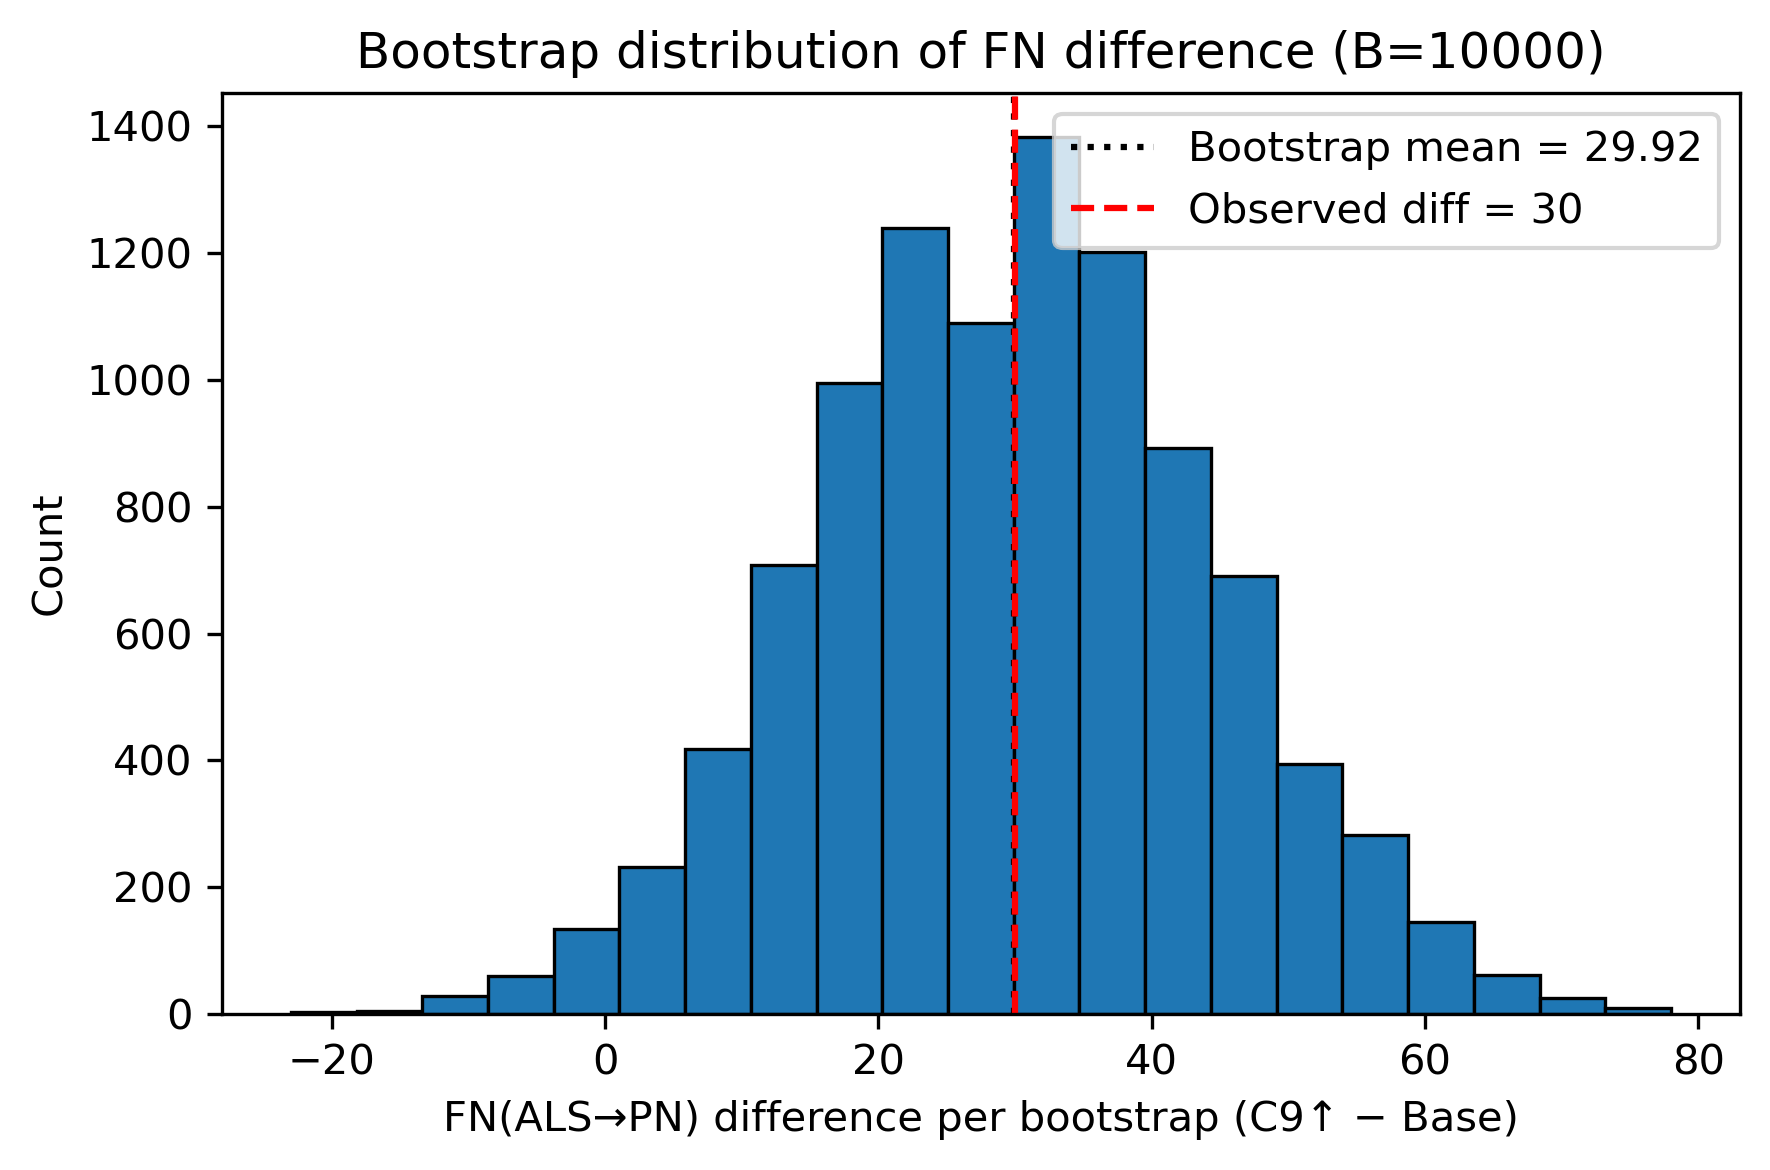


Saved bootstrap arrays to bootstrap_confmats_base_c9.npz


In [ ]:

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if "model" not in globals():
    raise RuntimeError("Trained `model` not found in globals().")
if "thr" not in globals():
    print("Warning: decision threshold `thr` not found; defaulting to 0.5")
    thr = 0.5

# -------------- Build COMMON test set (PN + ALS) --------------
cond_series = pick_condition_series(base.obs)      # "pn"/"als"
split_series = ensure_split_series(base.obs)       # "train"/"test"
valid_mask = cond_series.isin(["pn", "als"])
y_all = (cond_series.values == "als").astype(int)  # PN=0, ALS=1

test_mask = (split_series.values == "test") & valid_mask.values
if test_mask.sum() == 0:
    raise ValueError("No PN/ALS cells in base test split.")

Eb_test, Ec9_test, common_names, base_pos_idx = align_on_common_obs(
    base, C9orf72_als_up, E_base, E_c9_als_up, subset_index=np.where(test_mask)[0]
)
y_test = y_all[base_pos_idx]
N = len(y_test)
print(f"Common TEST cells: {N} | PN={int((y_test==0).sum())} ALS={int((y_test==1).sum())}")

# -------------- Single inference (reuse for all bootstraps) --------------
probs_base = infer_probs(model, Eb_test, device=device)
probs_c9   = infer_probs(model, Ec9_test, device=device)
pred_base  = (probs_base >= thr).astype(int)
pred_c9    = (probs_c9   >= thr).astype(int)

# Observed FN(ALS→PN) counts and their difference
FN_base_obs = int(np.sum((y_test==1) & (pred_base==0)))
FN_c9_obs   = int(np.sum((y_test==1) & (pred_c9==0)))
diff_obs    = FN_c9_obs - FN_base_obs
print(f"Observed FN(ALS→PN): Base={FN_base_obs} | C9↑={FN_c9_obs} | Diff (C9↑-Base)={diff_obs}")

# -------------- Bootstrap (paired over common test cells) --------------
B = 10000  # number of bootstrap replicates (change as you like)
rng = np.random.default_rng(0)

# store confusion matrices (optional)
cms_base = np.zeros((B, 2, 2), dtype=int)
cms_c9   = np.zeros((B, 2, 2), dtype=int)

FN_base_boot = np.zeros(B, dtype=int)
FN_c9_boot   = np.zeros(B, dtype=int)
diff_boot    = np.zeros(B, dtype=int)

als_true = (y_test == 1)

for b in range(B):
    idx = rng.choice(N, size=N, replace=True)  # resample common test cells
    yb   = y_test[idx]
    pb_b = pred_base[idx]
    pb_c = pred_c9[idx]

    # confusion matrices with fixed label order [PN=0, ALS=1]
    cms_base[b] = confusion_matrix(yb, pb_b, labels=[0,1])
    cms_c9[b]   = confusion_matrix(yb, pb_c, labels=[0,1])

    # FN(ALS→PN) counts in this bootstrap sample
    FN_base_boot[b] = int(np.sum((yb==1) & (pb_b==0)))
    FN_c9_boot[b]   = int(np.sum((yb==1) & (pb_c==0)))
    diff_boot[b]    = FN_c9_boot[b] - FN_base_boot[b]

# -------------- Summaries, CI, and p-values --------------
mean_base = FN_base_boot.mean()
mean_c9   = FN_c9_boot.mean()
mean_diff = diff_boot.mean()
ci_base   = ci95(FN_base_boot)
ci_c9     = ci95(FN_c9_boot)
ci_diff   = ci95(diff_boot)

print("\nBootstrap (paired) summaries across B replicates:")
print(f"FN Base: mean={mean_base:.1f}, 95% CI={ci_base[0]:.0f}..{ci_base[1]:.0f}")
print(f"FN C9↑:  mean={mean_c9:.1f}, 95% CI={ci_c9[0]:.0f}..{ci_c9[1]:.0f}")
print(f"Diff (C9↑-Base): mean={mean_diff:.2f}, 95% CI={ci_diff[0]:.2f}..{ci_diff[1]:.2f}")
print(f"Observed diff = {diff_obs}")

# Two-sided bootstrap p-value (centered)
center = mean_diff
t_obs  = abs(diff_obs - center)
ts     = abs(diff_boot - center)
p_two  = (np.sum(ts >= t_obs) + 1) / (B + 1)

# One-sided p-value for the “improvement” hypothesis: C9 reduces FN → diff < 0
if diff_obs < 0:
    p_one = (np.sum(diff_boot <= diff_obs) + 1) / (B + 1)
else:
    p_one = (np.sum(diff_boot >= diff_obs) + 1) / (B + 1)

print(f"\nTwo-sided bootstrap p-value: {p_two:.4f}")
print(f"One-sided p-value (H1: C9 reduces FN → diff < 0): {p_one:.4f}")

# -------------- Distribution plot --------------
plt.figure(figsize=(6,4))
plt.hist(diff_boot, bins=21, edgecolor="black", linewidth=0.8)  # black outlines
plt.axvline(mean_diff, color="k", linestyle=":", label=f"Bootstrap mean = {mean_diff:.2f}")
plt.axvline(diff_obs, color="red", linestyle="--", label=f"Observed diff = {diff_obs}")
plt.xlabel("FN(ALS→PN) difference per bootstrap (C9↑ − Base)")
plt.ylabel("Count")
plt.title(f"Bootstrap distribution of FN difference (B={B})")
plt.legend()
plt.tight_layout()
plt.savefig("bootstrap_FN_diff_hist.png", bbox_inches="tight")
plt.show()

# -------------- (Optional) Save confusion matrices --------------
np.savez_compressed(
    "bootstrap_confmats_base_c9.npz",
    cms_base=cms_base, cms_c9=cms_c9,
    FN_base_boot=FN_base_boot, FN_c9_boot=FN_c9_boot, diff_boot=diff_boot,
    FN_base_obs=FN_base_obs, FN_c9_obs=FN_c9_obs, diff_obs=diff_obs
)
print("\nSaved bootstrap arrays to bootstrap_confmats_base_c9.npz")


**Figure 5**: Based on the 10,000 bootstraps, we see that the difference of 30 cells comes very close to the bootstrap mean of over 29 cells. This means that our difference is not statistically significant, and that we can conclude that based on this preliminary analysis, increasing the expression of _C9orf72_ 4-folds does not seem to help in shifting the disease state of ALS cells. Perhaps perturbing any of the remaining 42 genes might have more drastic changes, but that is limited by the access to GPU resources. 

## Supplemental Data for Multiple Perturbations

This data is **NOT** well-organized, but follows a similar structure. The main difference here is that most of this analysis is performed on data that was subsetted to only 5,000 cells. 

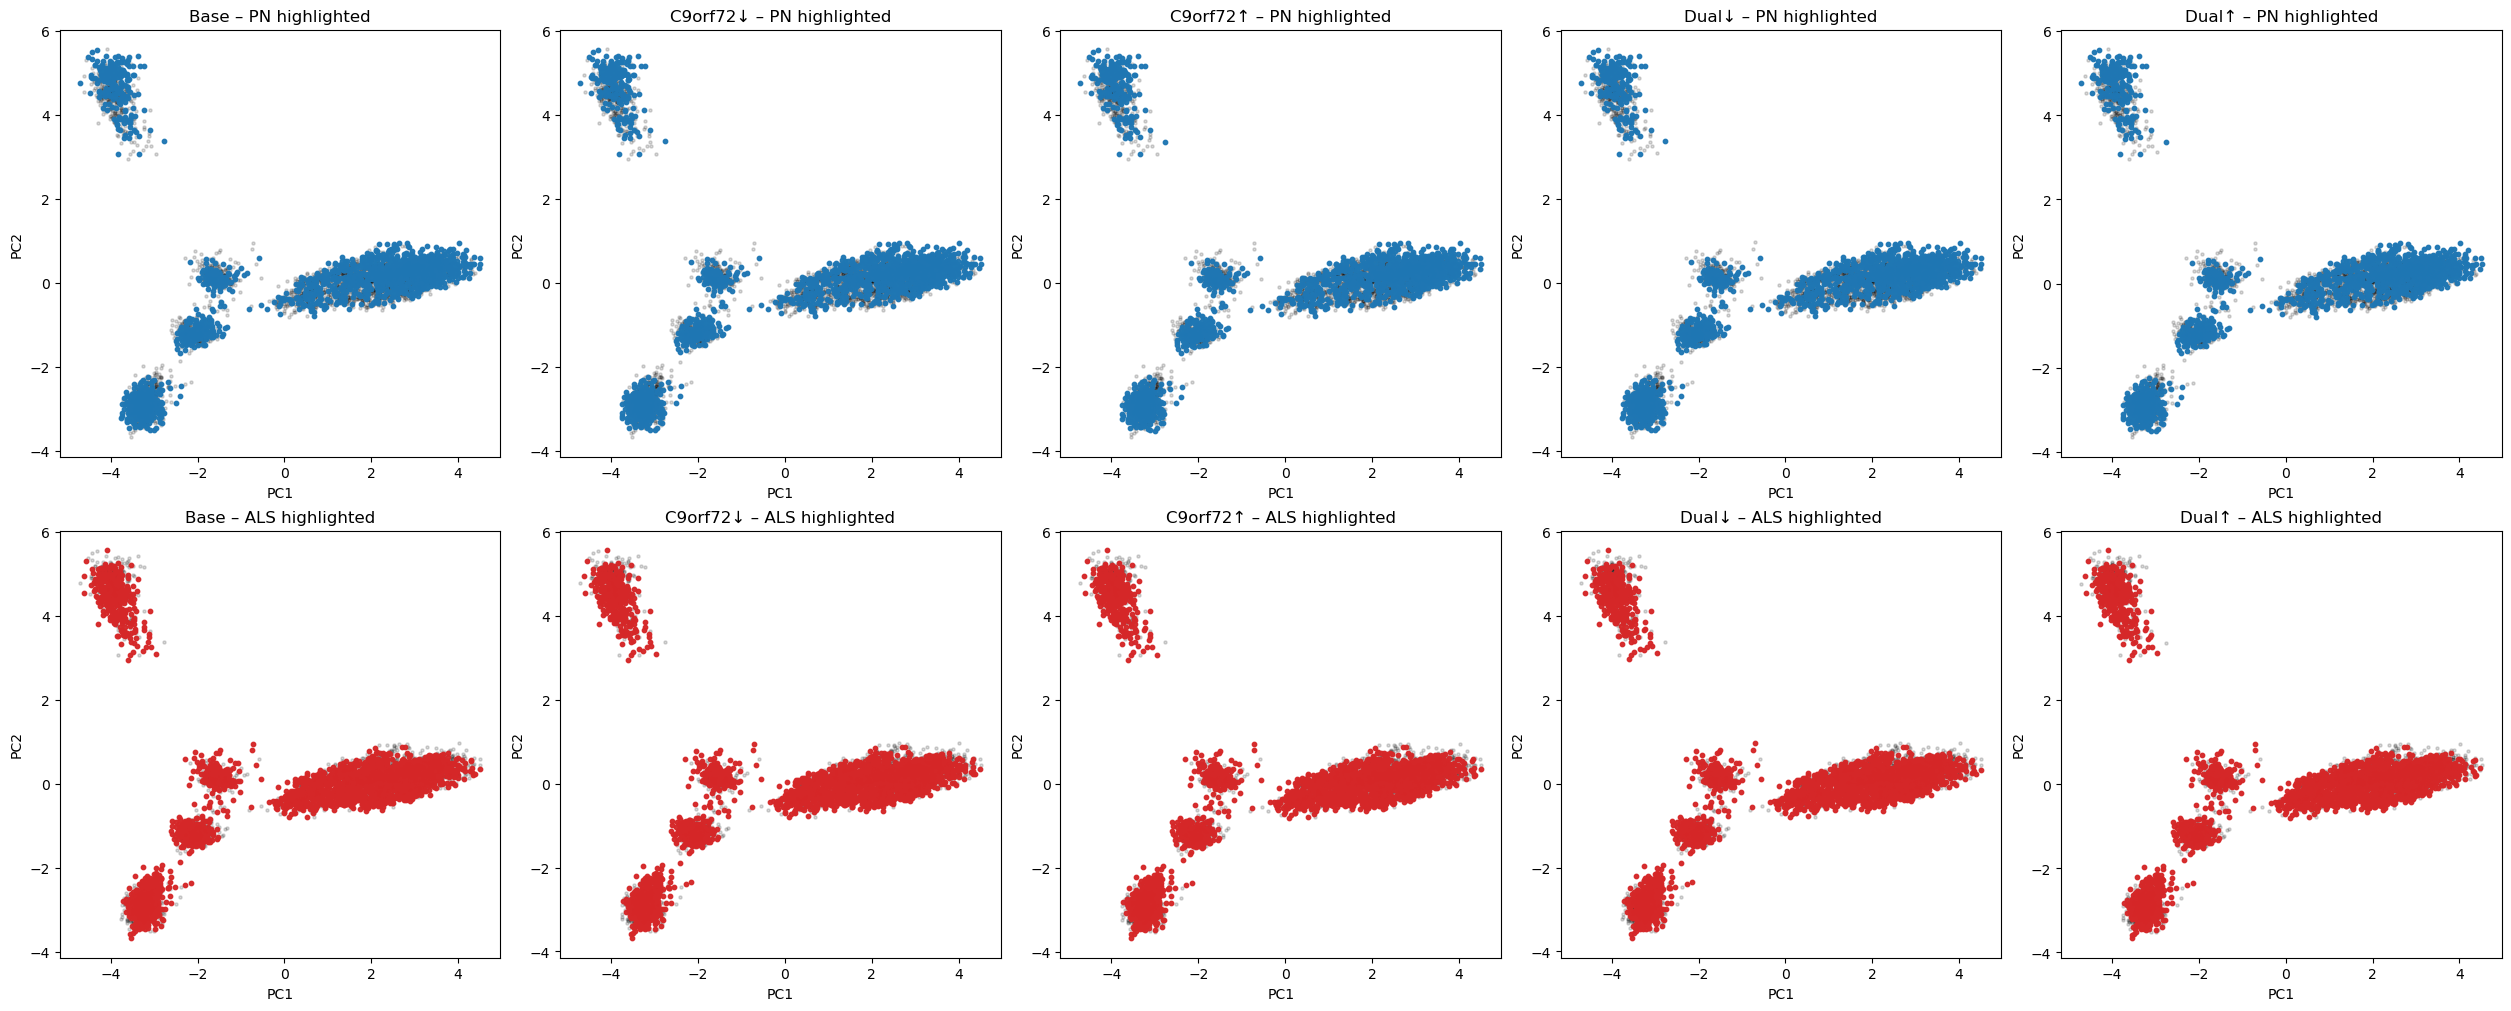

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np":"pn","control":"pn"})

labels_base    = norm_condition_df(base.obs)
labels_c9_dn   = norm_condition_df(C9orf72_als_down.obs)
labels_c9_up   = norm_condition_df(C9orf72_als_up.obs)
labels_dual_dn = norm_condition_df(dual_als_down.obs)
labels_dual_up = norm_condition_df(dual_als_up.obs)

panels = [
    ("Base",        E_base,        labels_base),
    ("C9orf72↓",    E_c9_als_dn,   labels_c9_dn),
    ("C9orf72↑",    E_c9_als_up,   labels_c9_up),
    ("Dual↓",       E_dual_als_dn, labels_dual_dn),
    ("Dual↑",       E_dual_als_up, labels_dual_up),
]

fig, axes = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)
for i, (name, E, lab) in enumerate(panels):
    P = PCA(n_components=2, random_state=0).fit_transform(E)
    m_als = lab.values == "als"
    m_pn  = lab.values == "pn"

    ax = axes[0, i]
    ax.scatter(P[:,0], P[:,1], s=5, c="#000000", alpha=0.15)
    ax.scatter(P[m_pn,0], P[m_pn,1], s=10, c="#1f77b4", alpha=0.95)
    ax.set_title(f"{name} – PN highlighted")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

    ax = axes[1, i]
    ax.scatter(P[:,0], P[:,1], s=5, c="#000000", alpha=0.15)
    ax.scatter(P[m_als,0], P[m_als,1], s=10, c="#d62728", alpha=0.95)
    ax.set_title(f"{name} – ALS highlighted")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

plt.savefig("pca_grid_2x5.png", dpi=300)
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


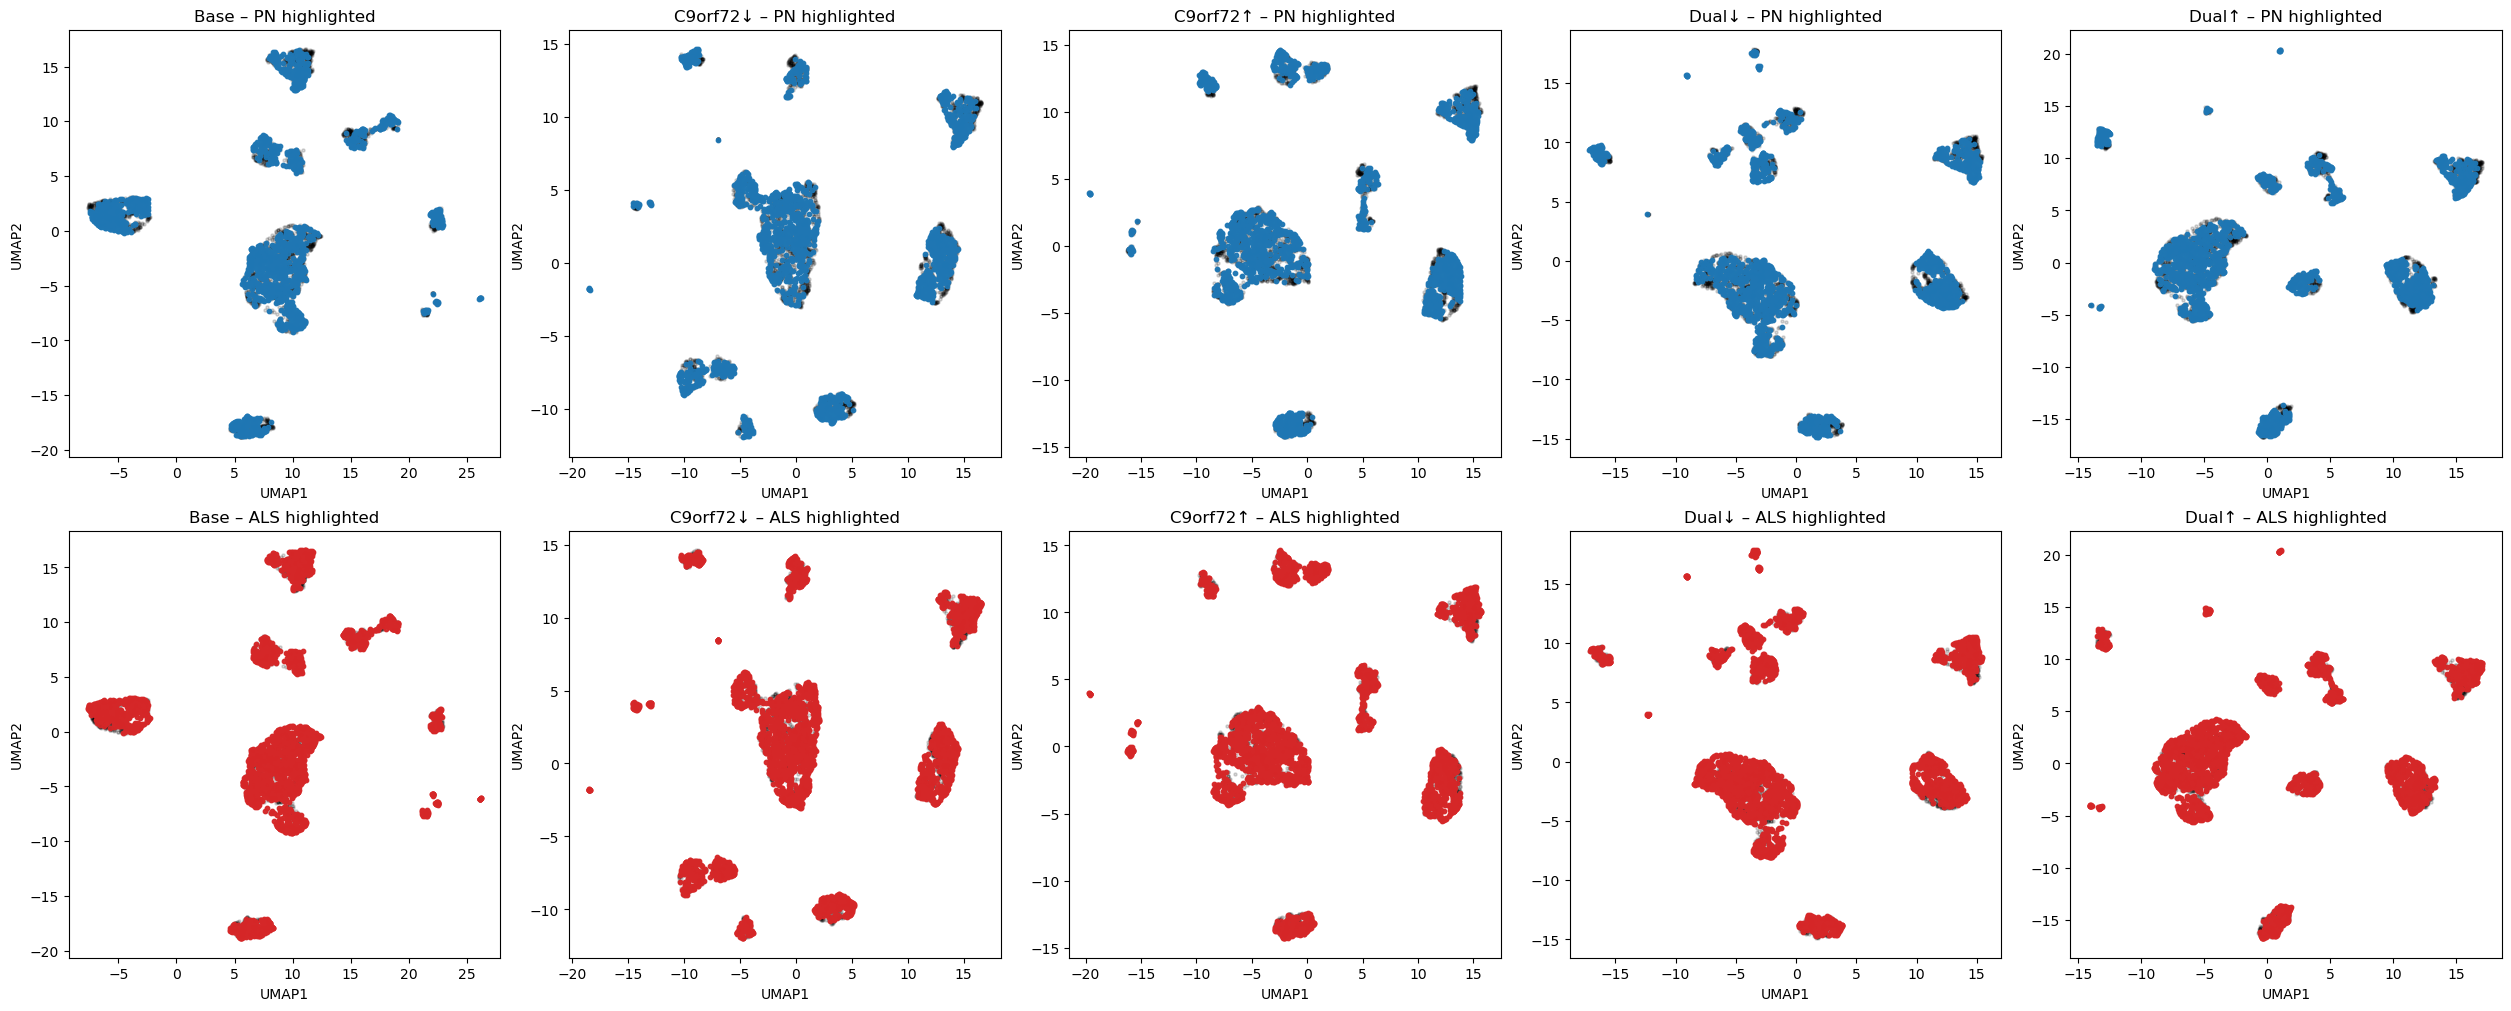

In [18]:
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # ensure imported above

labels_base    = norm_condition_df(base.obs)
labels_c9_dn   = norm_condition_df(C9orf72_als_down.obs)
labels_c9_up   = norm_condition_df(C9orf72_als_up.obs)
labels_dual_dn = norm_condition_df(dual_als_down.obs)
labels_dual_up = norm_condition_df(dual_als_up.obs)

panels = [
    ("Base",        E_base,        labels_base),
    ("C9orf72↓",    E_c9_als_dn,   labels_c9_dn),
    ("C9orf72↑",    E_c9_als_up,   labels_c9_up),
    ("Dual↓",       E_dual_als_dn, labels_dual_dn),
    ("Dual↑",       E_dual_als_up, labels_dual_up),
]

fig, axes = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)
for i, (name, E, lab) in enumerate(panels):
    U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)
    m_als = lab.values == "als"
    m_pn  = lab.values == "pn"

    ax = axes[0, i]
    ax.scatter(U[:,0], U[:,1], s=5, c="#000000", alpha=0.15)
    ax.scatter(U[m_pn,0], U[m_pn,1], s=10, c="#1f77b4", alpha=0.95)
    ax.set_title(f"{name} – PN highlighted")
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

    ax = axes[1, i]
    ax.scatter(U[:,0], U[:,1], s=5, c="#000000", alpha=0.15)
    ax.scatter(U[m_als,0], U[m_als,1], s=10, c="#d62728", alpha=0.95)
    ax.set_title(f"{name} – ALS highlighted")
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

plt.savefig("umap_grid_2x5.png", dpi=300)
plt.show()

/var/folders/8m/dxckcnm51258h_69j8ctn3c40000gn/T/ipykernel_5313/1351500624.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(all_types))
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use

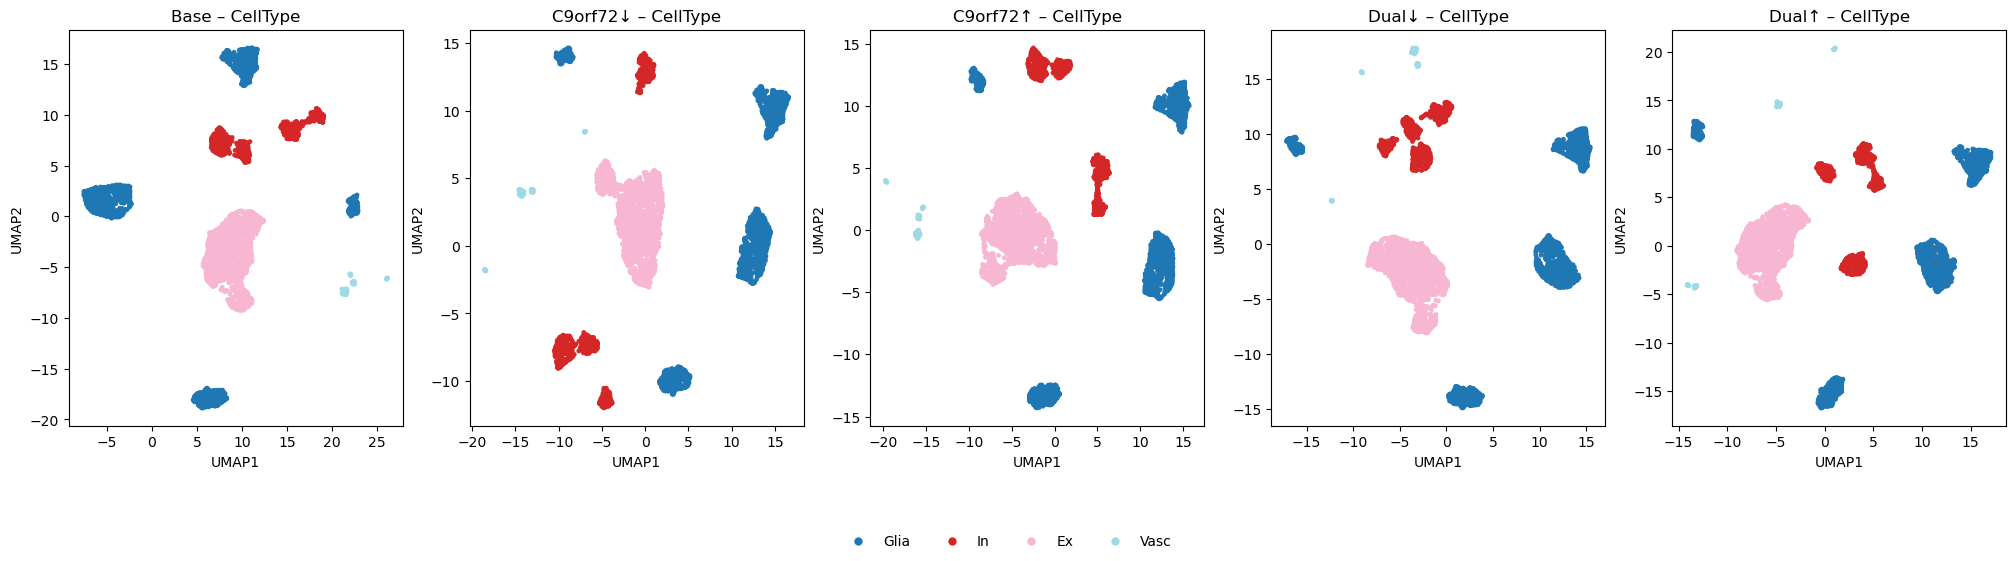

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import umap

def get_celltype_series(obs):
    for k in ["CellClass"]:
        if k in obs.columns:
            return obs[k].astype(str).fillna("Unknown")
    raise KeyError("No CellType-like column found.")

panels_data = [
    ("Base",      E_base,        base),
    ("C9orf72↓",  E_c9_als_dn,   C9orf72_als_down),
    ("C9orf72↑",  E_c9_als_up,   C9orf72_als_up),
    ("Dual↓",     E_dual_als_dn, dual_als_down),
    ("Dual↑",     E_dual_als_up, dual_als_up),
]

cts_list = [get_celltype_series(a.obs) for _, _, a in panels_data]
all_types = pd.unique(pd.concat(cts_list, ignore_index=True))
cmap = plt.cm.get_cmap("tab20", len(all_types))
type_to_color = {t: cmap(i) for i, t in enumerate(all_types)}

fig, axes = plt.subplots(1, 5, figsize=(25, 6), constrained_layout=False)
for ax, (name, E, a), ct in zip(axes, panels_data, cts_list):
    U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)
    colors = [type_to_color.get(t, (0.5, 0.5, 0.5, 0.7)) for t in ct.values]
    ax.scatter(U[:, 0], U[:, 1], s=6, c=colors, alpha=0.95)
    ax.set_title(f"{name} – CellType")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=6,
                  markerfacecolor=type_to_color[t], markeredgecolor="none", label=t)
           for t in all_types]
fig.subplots_adjust(bottom=0.22)
fig.legend(handles=handles, loc="lower center", ncol=min(8, len(handles)), frameon=False)
plt.savefig("umap_celltype_grid_1x5.png", dpi=300)
plt.show()

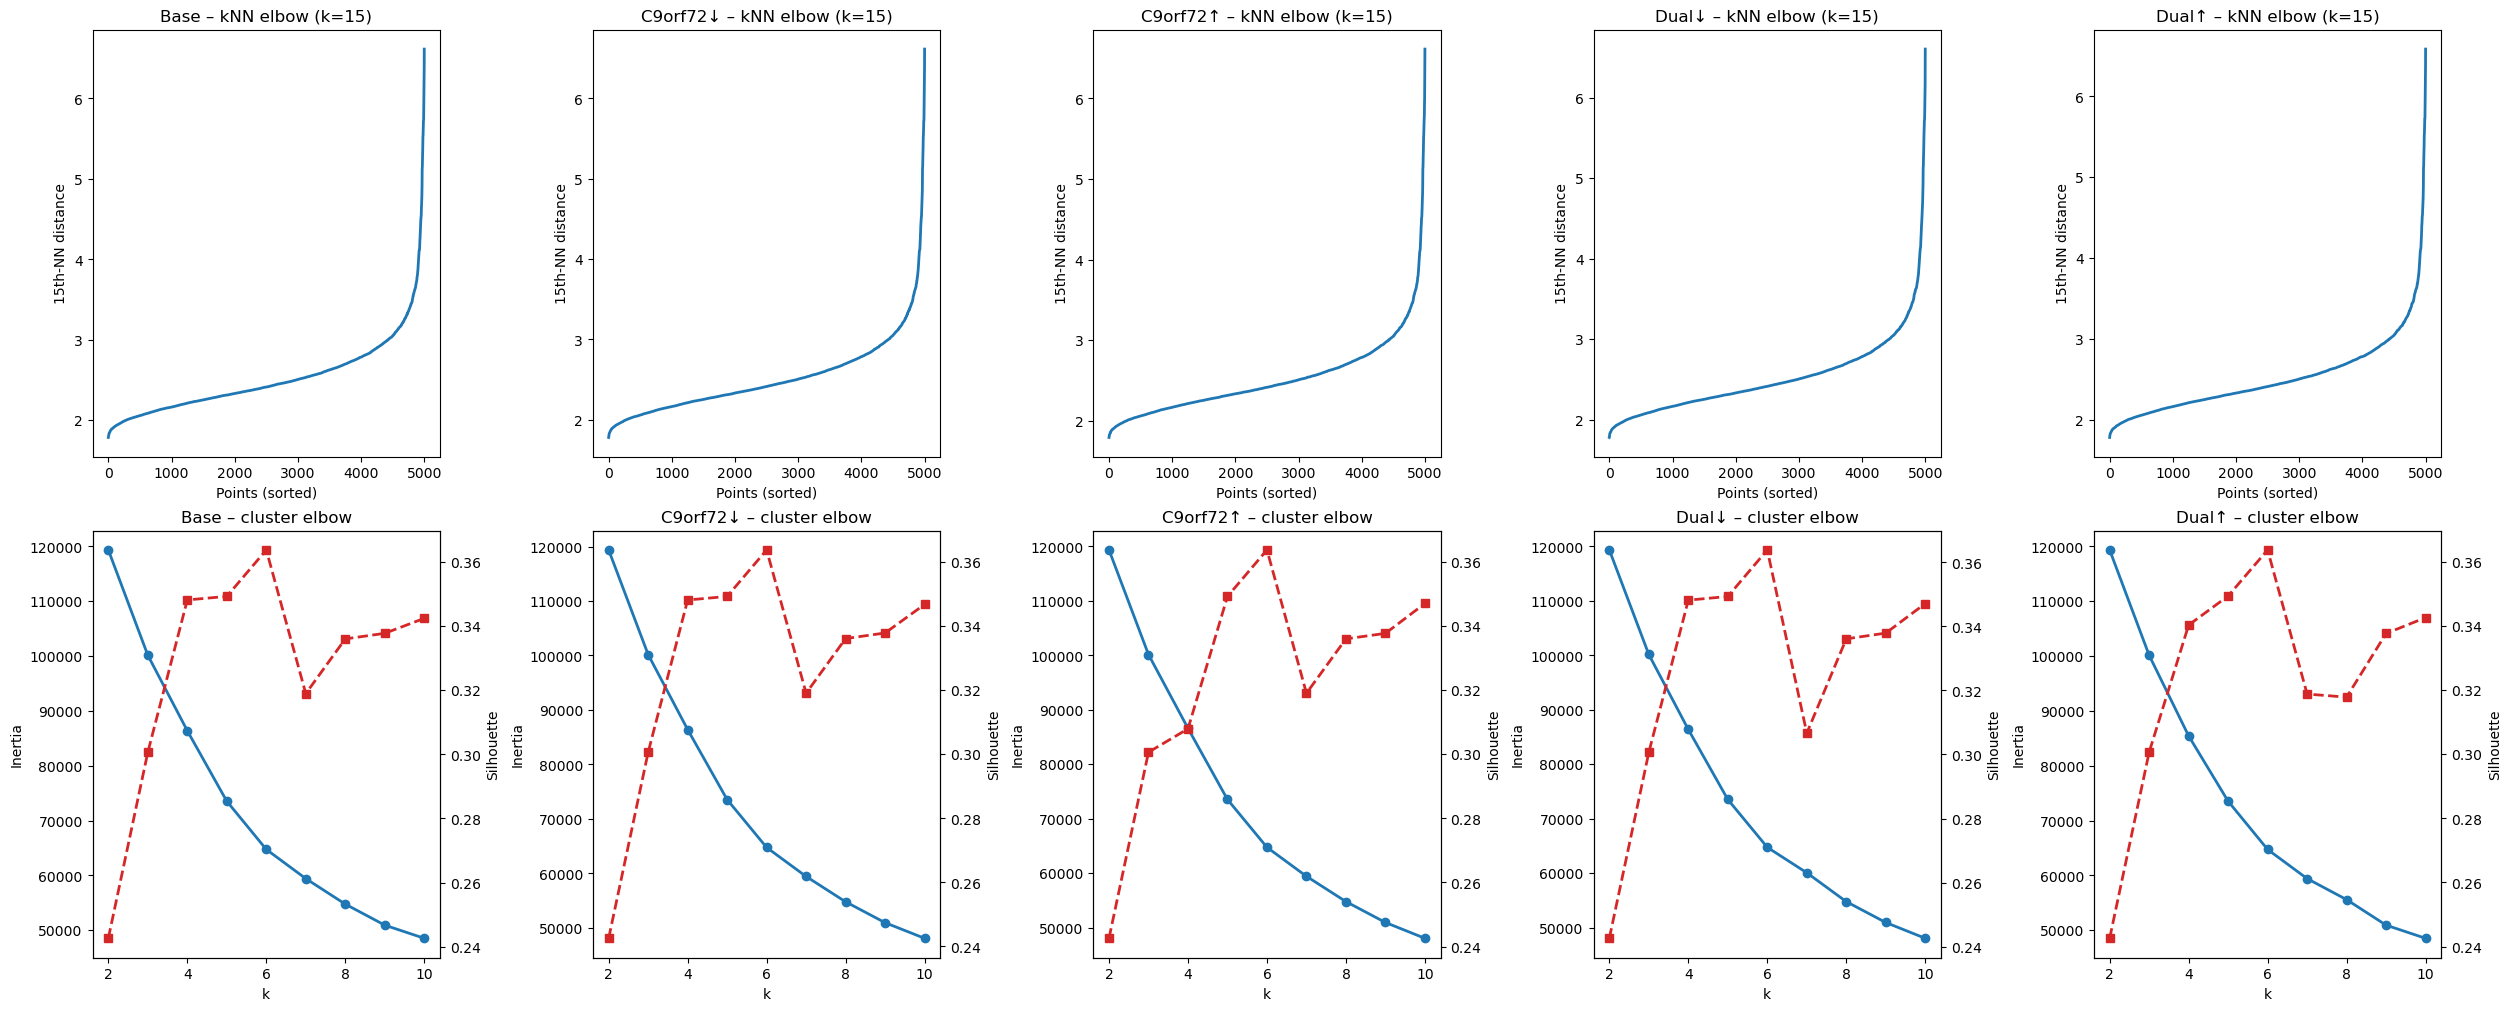

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

names = ["Base","C9orf72↓","C9orf72↑","Dual↓","Dual↑"]
embeds = [E_base, E_c9_als_dn, E_c9_als_up, E_dual_als_dn, E_dual_als_up]

def knn_distance_elbow(X, n_neighbors=15):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
    dists, _ = nn.kneighbors(X)
    kth = dists[:, n_neighbors-1]
    return np.sort(kth)

def cluster_elbow_metrics(X, ks=range(2,11), sample_size=3000, rs=0):
    inertias, sils = [], []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=rs).fit(X)
        inertias.append(km.inertia_)
        n = min(sample_size, X.shape[0])
        if n < X.shape[0]:
            idx = np.random.default_rng(rs).choice(X.shape[0], size=n, replace=False)
            sil = silhouette_score(X[idx], km.labels_[idx], metric="euclidean")
        else:
            sil = silhouette_score(X, km.labels_, metric="euclidean")
        sils.append(sil)
    return np.array(inertias), np.array(sils)

fig, axes = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=True)

for i, (name, E) in enumerate(zip(names, embeds)):
    elbow = knn_distance_elbow(E, n_neighbors=15)
    ax = axes[0, i]
    ax.plot(np.arange(len(elbow)), elbow, lw=2)
    ax.set_title(f"{name} – kNN elbow (k=15)")
    ax.set_xlabel("Points (sorted)")
    ax.set_ylabel("15th-NN distance")

ks = np.arange(2, 11)
for i, (name, E) in enumerate(zip(names, embeds)):
    inertias, sils = cluster_elbow_metrics(E, ks=ks, sample_size=3000, rs=0)
    ax1 = axes[1, i]
    ax2 = ax1.twinx()
    ax1.plot(ks, inertias, marker="o", lw=2)
    ax2.plot(ks, sils, marker="s", lw=2, ls="--", color="#d62728")
    ax1.set_title(f"{name} – cluster elbow")
    ax1.set_xlabel("k")
    ax1.set_ylabel("Inertia")
    ax2.set_ylabel("Silhouette")

plt.savefig("knn_and_cluster_elbows_2x5.png", dpi=300)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/8m/dxckcnm51258h_69j8ctn3c40000gn/T/ipykernel_5313/3536210374.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated i

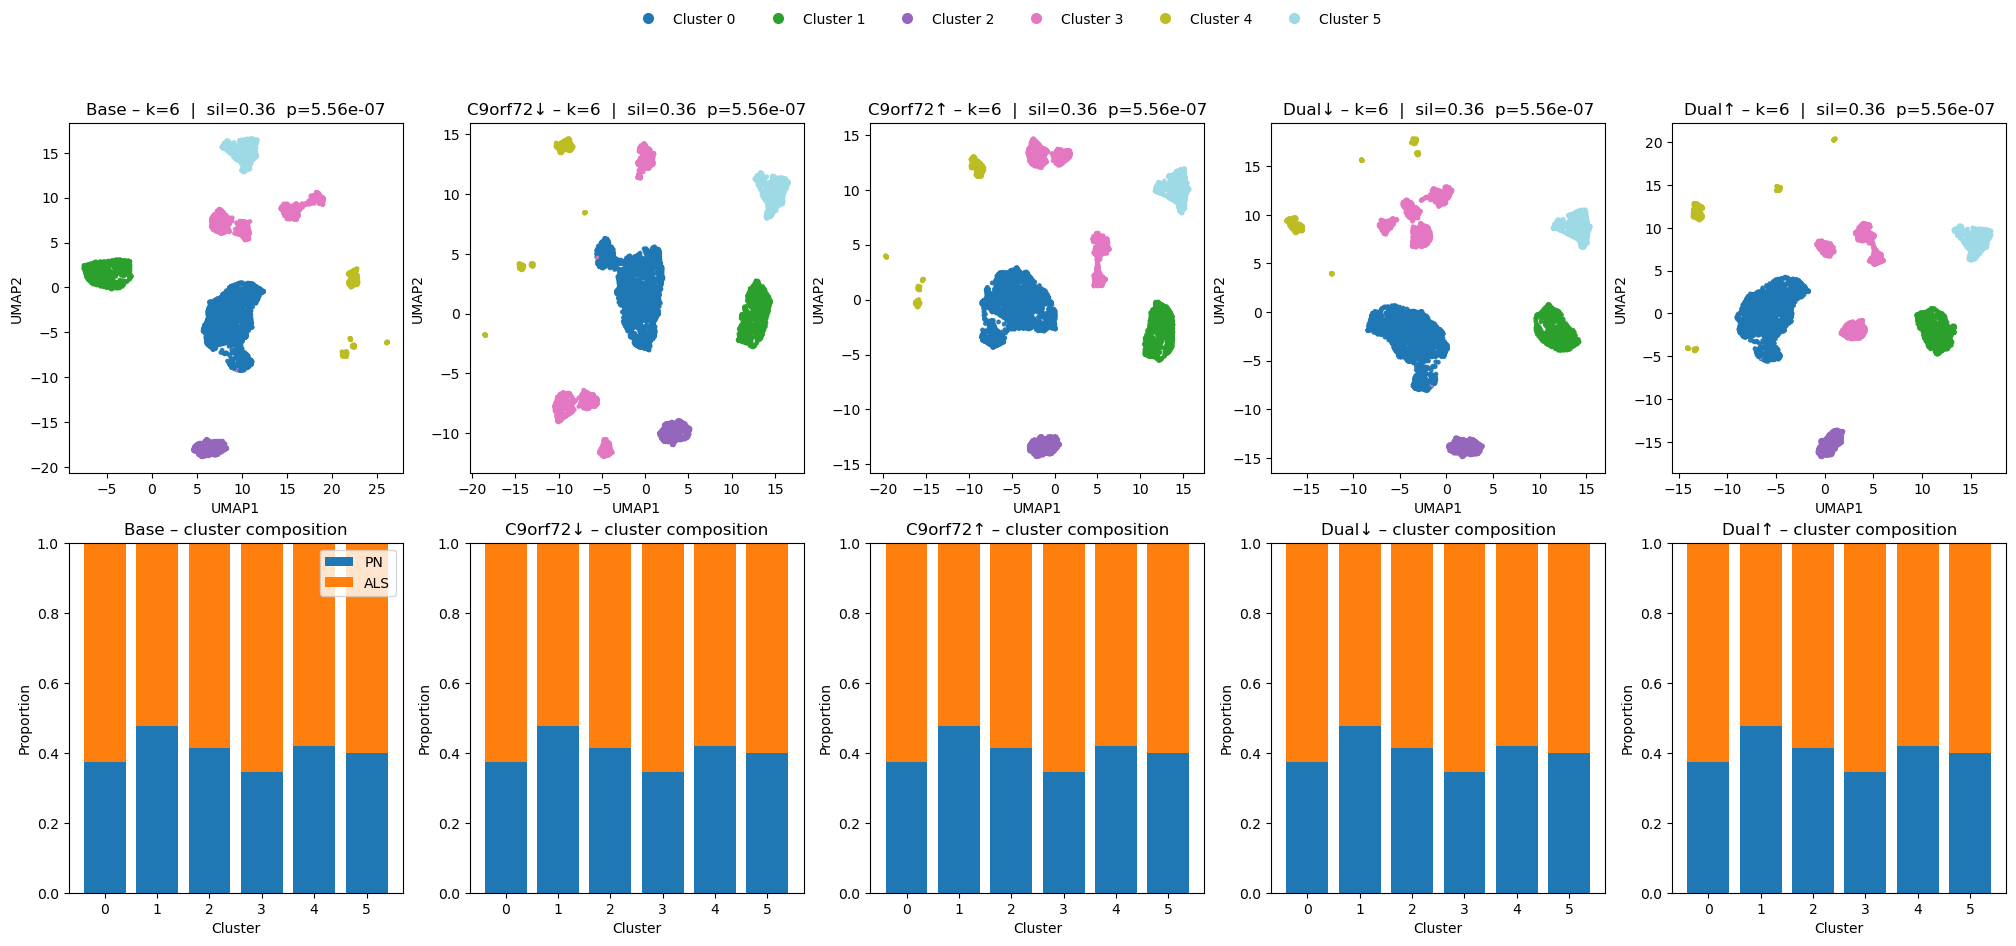

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np":"pn","control":"pn"})

k = 6
names = ["Base","C9orf72↓","C9orf72↑","Dual↓","Dual↑"]
embeds = [E_base, E_c9_als_dn, E_c9_als_up, E_dual_als_dn, E_dual_als_up]
adatas = [base, C9orf72_als_down, C9orf72_als_up, dual_als_down, dual_als_up]
conds  = [norm_condition_df(a.obs) for a in adatas]

results = []
for name, E, a, c in zip(names, embeds, adatas, conds):
    km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(E)
    lab = km.labels_.astype(int)
    a.obs["k6"] = pd.Categorical(lab)
    U = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=0).fit_transform(E)
    sil = silhouette_score(E, lab, metric="euclidean")
    tab = pd.crosstab(a.obs["k6"], c)
    for col in ["als","pn"]:
        if col not in tab.columns:
            tab[col] = 0
    tab = tab[["pn","als"]].sort_index()
    chi2, p, dof, exp = chi2_contingency(tab.values) if tab.values.sum() > 0 else (np.nan, np.nan, np.nan, None)
    prop = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    tab.to_csv(f"{name}_k6_cluster_condition_counts.csv")
    prop.to_csv(f"{name}_k6_cluster_condition_props.csv")
    a.write_h5ad(f"adata_{name.replace('↓','dn').replace('↑','up').lower()}_k6.h5ad")
    results.append((name, U, lab, prop, sil, p))

cmap = plt.cm.get_cmap("tab20")
fig, axes = plt.subplots(2, 5, figsize=(25, 10), constrained_layout=False)

for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[0, i]
    ax.scatter(U[:,0], U[:,1], c=lab, s=6, cmap=cmap, vmin=0, vmax=k-1, alpha=0.9)
    ax.set_title(f"{name} – k={k}  |  sil={sil:.2f}  p={p:.2e}")
    ax.set_xlabel("UMAP1"); ax.set_ylabel("UMAP2")

for i, (name, U, lab, prop, sil, p) in enumerate(results):
    ax = axes[1, i]
    x = np.arange(prop.shape[0])
    ax.bar(x, prop["pn"].values, label="PN")
    ax.bar(x, prop["als"].values, bottom=prop["pn"].values, label="ALS")
    ax.set_xticks(x)
    ax.set_xticklabels([str(k_) for k_ in range(prop.shape[0])])
    ax.set_ylim(0, 1)
    ax.set_xlabel("Cluster"); ax.set_ylabel("Proportion")
    ax.set_title(f"{name} – cluster composition")
    if i == 0:
        ax.legend()

handles = [Line2D([0], [0], marker="o", linestyle="None", markersize=8,
                  markerfacecolor=cmap(i/(k-1)), markeredgecolor="none", label=f"Cluster {i}")
           for i in range(k)]
fig.subplots_adjust(top=0.88)
fig.legend(handles=handles, loc="upper center", ncol=k, frameon=False)

plt.savefig("k6_umap_clusters_and_compositions_with_legend_2x5.png", dpi=300, bbox_inches="tight")
plt.show()

      group  n_ALS  n_PN  base_dist_ALS_to_PN  dist_ALSpert_to_PNbase  \
0  C9orf72↓   3018  1982             0.836374                0.835532   
1  C9orf72↑   3018  1982             0.836374                0.838091   
2     Dual↓   3018  1982             0.836374                0.833942   
3     Dual↑   3018  1982             0.836374                0.839575   

   dist_ALSpert_to_PNpert  delta_vs_basePN  pct_change_vs_basePN  \
0                0.835532        -0.000842             -0.100712   
1                0.838091         0.001717              0.205259   
2                0.833942        -0.002432             -0.290813   
3                0.839575         0.003201              0.382696   

   towardness_along_base_axis  
0                    0.000853  
1                   -0.001701  
2                    0.002475  
3                   -0.003145  


/var/folders/8m/dxckcnm51258h_69j8ctn3c40000gn/T/ipykernel_5313/2195703088.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


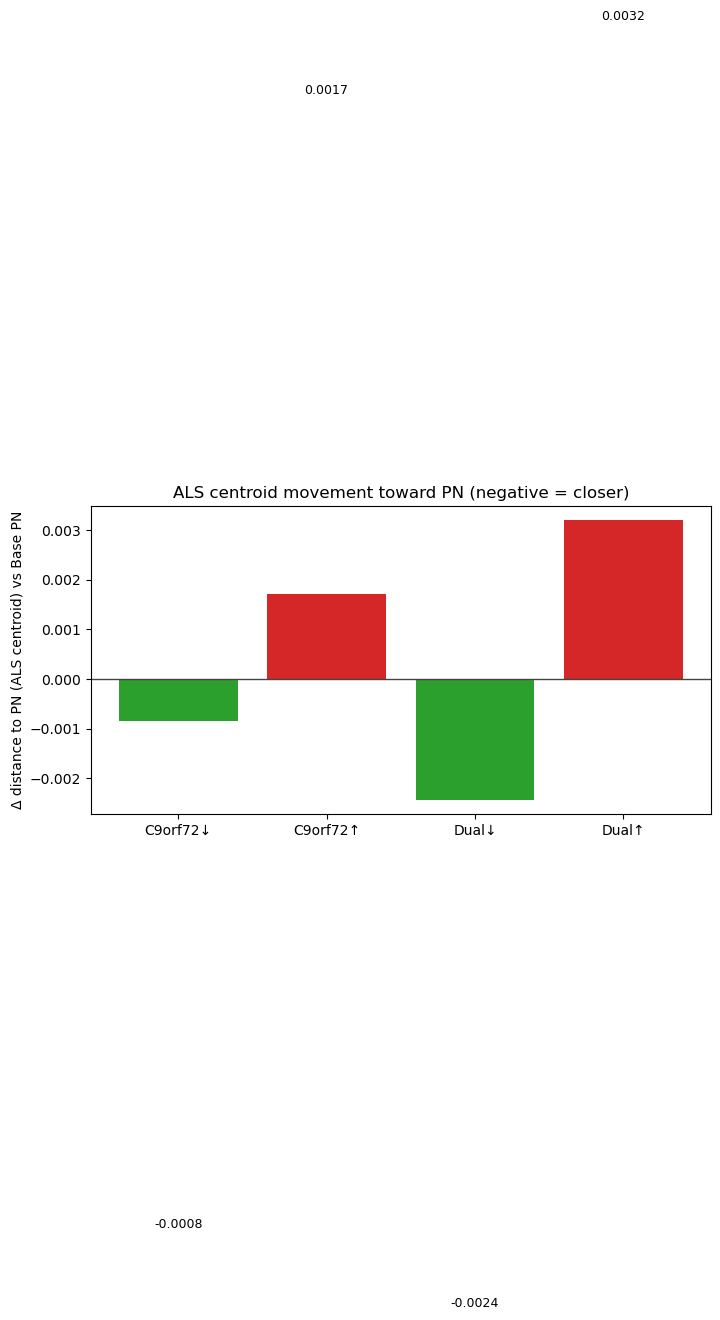

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np":"pn","control":"pn"})

def centroid(X):
    return np.nanmean(X, axis=0)

def centroids_by_condition(E, obs_df):
    lab = norm_condition_df(obs_df)
    m_als = lab.values == "als"
    m_pn  = lab.values == "pn"
    if not m_als.any() or not m_pn.any():
        return None, None, int(m_als.sum()), int(m_pn.sum())
    return centroid(E[m_als]), centroid(E[m_pn]), int(m_als.sum()), int(m_pn.sum())

names  = ["Base","C9orf72↓","C9orf72↑","Dual↓","Dual↑"]
embeds = [E_base, E_c9_als_dn, E_c9_als_up, E_dual_als_dn, E_dual_als_up]
adatas = [base,  C9orf72_als_down, C9orf72_als_up, dual_als_down,  dual_als_up]

c_als_base, c_pn_base, nALS_b, nPN_b = centroids_by_condition(E_base, base.obs)
v_base = c_pn_base - c_als_base
L_base = np.linalg.norm(v_base) + 1e-12
u_base = v_base / L_base

rows = []
for name, E, a in zip(names[1:], embeds[1:], adatas[1:]):
    c_als_p, c_pn_p, nALS, nPN = centroids_by_condition(E, a.obs)
    d0 = float(np.linalg.norm(c_als_base - c_pn_base))
    d1_basePN  = float(np.linalg.norm(c_als_p - c_pn_base))
    d1_pertPN  = float(np.linalg.norm(c_als_p - c_pn_p))
    delta_basePN = d1_basePN - d0
    delta_pct = 100.0 * delta_basePN / d0 if d0 > 0 else np.nan
    towardness = float(np.dot(c_als_p - c_als_base, u_base))
    rows.append({
        "group": name,
        "n_ALS": nALS,
        "n_PN": nPN,
        "base_dist_ALS_to_PN": d0,
        "dist_ALSpert_to_PNbase": d1_basePN,
        "dist_ALSpert_to_PNpert": d1_pertPN,
        "delta_vs_basePN": delta_basePN,
        "pct_change_vs_basePN": delta_pct,
        "towardness_along_base_axis": towardness
    })

df = pd.DataFrame(rows)
df.to_csv("centroid_als_to_pn_movement.csv", index=False)
print(df)

plt.figure(figsize=(8,4))
colors = ["#2ca02c" if v<0 else "#d62728" for v in df["delta_vs_basePN"].values]
bars = plt.bar(df["group"], df["delta_vs_basePN"], color=colors)
plt.axhline(0, color="#444444", lw=1)
plt.ylabel("Δ distance to PN (ALS centroid) vs Base PN")
plt.title("ALS centroid movement toward PN (negative = closer)")
for b, v in zip(bars, df["delta_vs_basePN"].values):
    plt.text(b.get_x()+b.get_width()/2, v + (0.01 if v>=0 else -0.01), f"{v:.4f}", ha="center", va="bottom" if v>=0 else "top", fontsize=9)
plt.tight_layout()
plt.savefig("centroid_movement_als_toward_pn_bar.png", dpi=300)
plt.show()

      group  fisher_ratio_base  fisher_ratio_pert  fisher_ratio_delta  \
0  C9orf72↓           0.011389           0.011365           -0.000024   
1  C9orf72↑           0.011389           0.011436            0.000047   
2     Dual↓           0.011389           0.011322           -0.000067   
3     Dual↑           0.011389           0.011478            0.000089   

   median_knn_radius_delta  als_neighbor_pn_frac_base  \
0                      0.0                   0.253634   
1                      0.0                   0.253634   
2                      0.0                   0.253634   
3                      0.0                   0.253634   

   als_neighbor_pn_frac_pert  als_neighbor_pn_frac_delta  sliced_wasserstein  \
0                   0.253192                   -0.000442            0.000450   
1                   0.253126                   -0.000508            0.000486   
2                   0.253590                   -0.000044            0.000558   
3                   0.253324

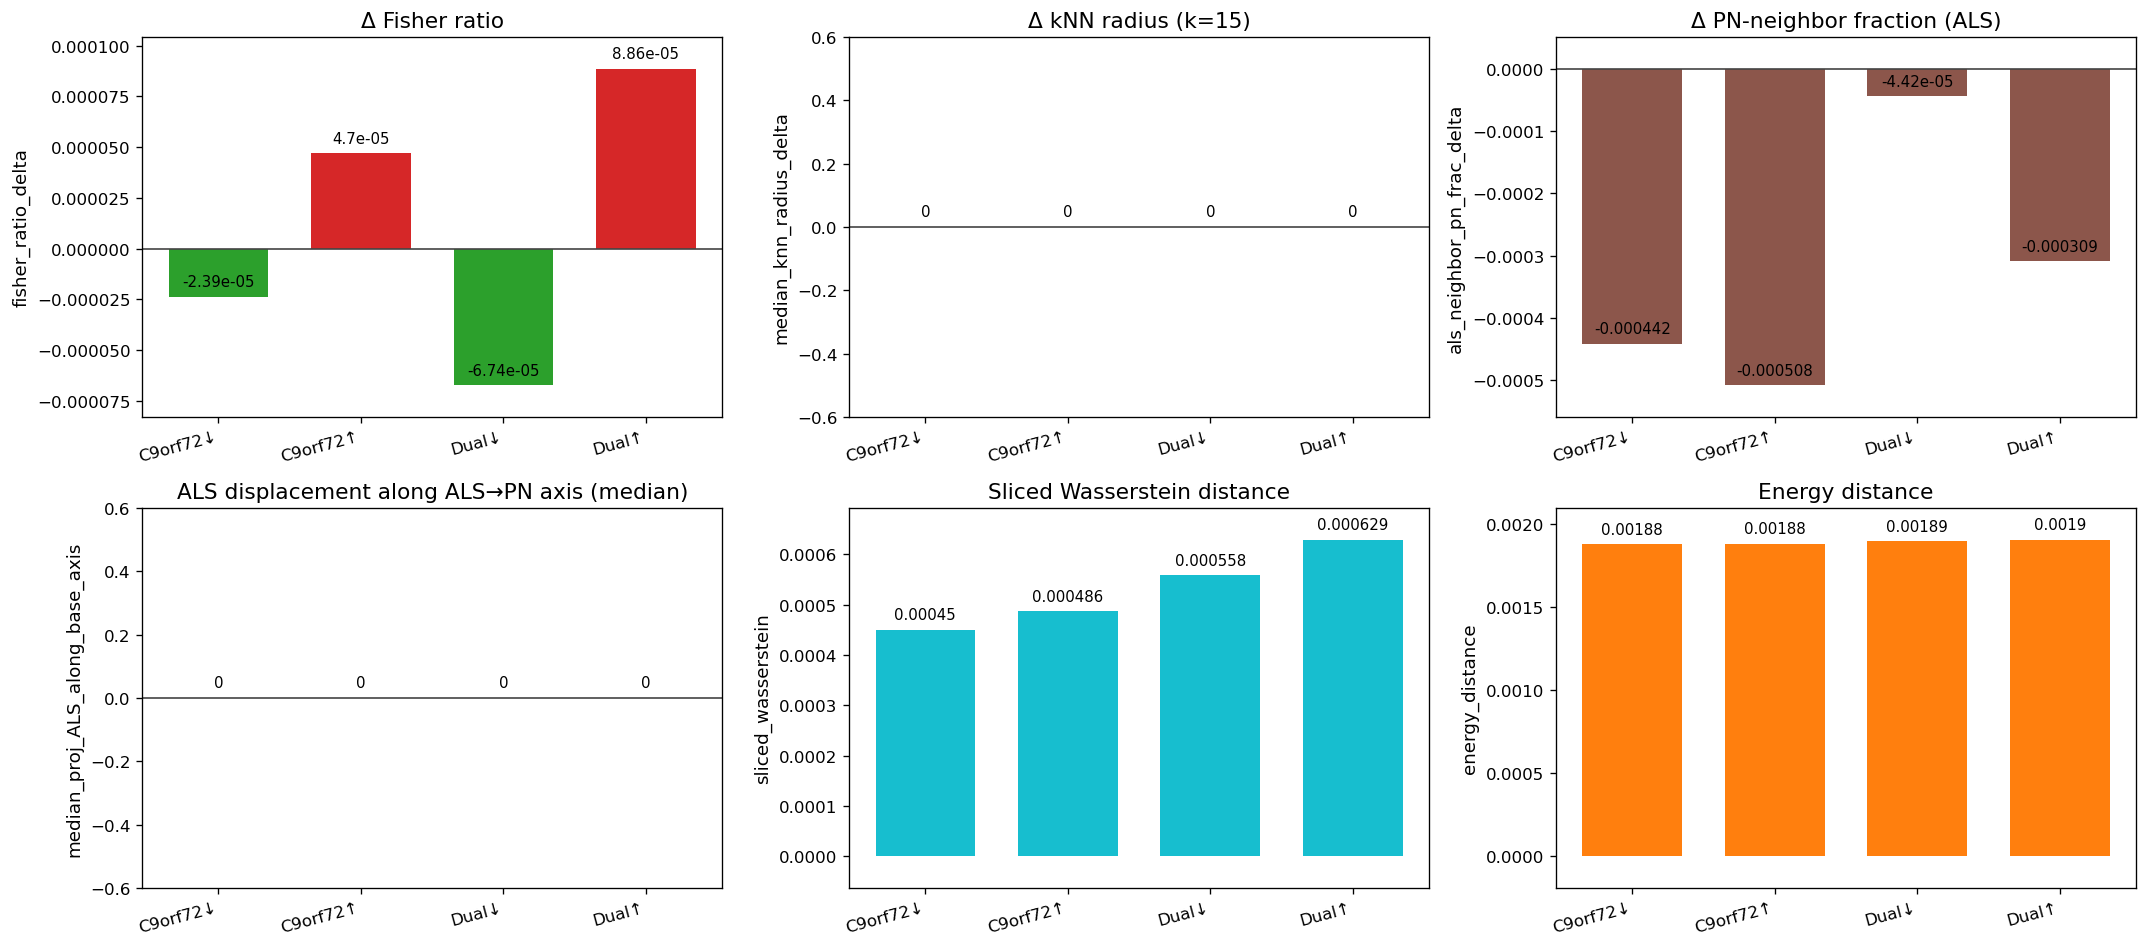

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist, pdist
from scipy.stats import wasserstein_distance

def norm_condition_df(df):
    if "Condition" in df.columns:
        s = df["Condition"].astype(str)
    elif "condition" in df.columns:
        s = df["condition"].astype(str)
    else:
        raise KeyError("Condition/condition column not found")
    return s.str.strip().str.lower().replace({"np":"pn","control":"pn"})

def align_on_obs(base_adata, pert_adata, E_base, E_pert):
    common = base_adata.obs_names.intersection(pert_adata.obs_names)
    bi = base_adata.obs_names.get_indexer(common)
    pi = pert_adata.obs_names.get_indexer(common)
    return E_base[bi], E_pert[pi], base_adata.obs.loc[common]

def centroid(X):
    return np.nanmean(X, axis=0)

def fisher_ratio(E, labels):
    m_als = labels.values == "als"
    m_pn  = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als = centroid(E[m_als]); c_pn = centroid(E[m_pn])
    between = np.linalg.norm(c_als - c_pn)**2
    s_als = np.mean(np.sum((E[m_als] - c_als)**2, axis=1))
    s_pn  = np.mean(np.sum((E[m_pn]  - c_pn )**2, axis=1))
    within = s_als + s_pn + 1e-12
    return float(between / within)

def knn_kth_radius(E, k=15):
    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(E)
    dists, _ = nn.kneighbors(E)
    return dists[:, -1]

def neighbor_label_fraction(E, labels, focus="als", target="pn", k=15):
    m_focus = labels.values == focus
    if not m_focus.any():
        return np.nan
    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(E)
    _, idx = nn.kneighbors(E[m_focus])
    idx = idx[:, 1:]
    lab_arr = labels.values
    targ = (lab_arr[idx] == target).mean(axis=1)
    return float(np.mean(targ))

def sliced_wasserstein(X, Y, n_proj=64, rs=0):
    rng = np.random.default_rng(rs)
    d = X.shape[1]
    acc = 0.0
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v = v / (np.linalg.norm(v) + 1e-12)
        Xp = X @ v
        Yp = Y @ v
        acc += wasserstein_distance(Xp, Yp)
    return float(acc / n_proj)

def energy_distance_multivariate(X, Y, sample=2000, rs=0):
    rng = np.random.default_rng(rs)
    n = min(sample, len(X), len(Y))
    Xi = rng.choice(len(X), size=n, replace=False)
    Yi = rng.choice(len(Y), size=n, replace=False)
    Xs = X[Xi]; Ys = Y[Yi]
    EXY = np.mean(cdist(Xs, Ys, metric="euclidean"))
    EXX = np.mean(pdist(Xs, metric="euclidean"))
    EYY = np.mean(pdist(Ys, metric="euclidean"))
    return float(2*EXY - EXX - EYY)

def median_projection_along_base_axis(Eb, Ep, labels):
    m_als = labels.values == "als"; m_pn = labels.values == "pn"
    if not m_als.any() or not m_pn.any():
        return np.nan
    c_als_b = centroid(Eb[m_als]); c_pn_b = centroid(Eb[m_pn])
    u = c_pn_b - c_als_b
    u = u / (np.linalg.norm(u) + 1e-12)
    disp = Ep - Eb
    proj = disp[m_als] @ u
    return float(np.median(proj))

names  = ["C9orf72↓","C9orf72↑","Dual↓","Dual↑"]
embeds = [E_c9_als_dn, E_c9_als_up, E_dual_als_dn, E_dual_als_up]
adatas = [C9orf72_als_down, C9orf72_als_up, dual_als_down, dual_als_up]

rows = []
for nm, Ep, ap in zip(names, embeds, adatas):
    Eb_al, Ep_al, obs_b = align_on_obs(base, ap, E_base, Ep)
    labs = norm_condition_df(obs_b)
    fr_base = fisher_ratio(Eb_al, labs)
    fr_pert = fisher_ratio(Ep_al, labs)
    fr_delta = fr_pert - fr_base
    r_base = knn_kth_radius(Eb_al, k=15)
    r_pert = knn_kth_radius(Ep_al, k=15)
    knn_radius_delta_med = float(np.median(r_pert - r_base))
    mix_base = neighbor_label_fraction(Eb_al, labs, focus="als", target="pn", k=15)
    mix_pert = neighbor_label_fraction(Ep_al, labs, focus="als", target="pn", k=15)
    mix_delta = mix_pert - mix_base if not np.isnan(mix_base) and not np.isnan(mix_pert) else np.nan
    swd = sliced_wasserstein(Eb_al, Ep_al, n_proj=64, rs=0)
    ed  = energy_distance_multivariate(Eb_al, Ep_al, sample=2000, rs=0)
    med_proj_along_axis = median_projection_along_base_axis(Eb_al, Ep_al, labs)
    rows.append({
        "group": nm,
        "fisher_ratio_base": fr_base,
        "fisher_ratio_pert": fr_pert,
        "fisher_ratio_delta": fr_delta,
        "median_knn_radius_delta": knn_radius_delta_med,
        "als_neighbor_pn_frac_base": mix_base,
        "als_neighbor_pn_frac_pert": mix_pert,
        "als_neighbor_pn_frac_delta": mix_delta,
        "sliced_wasserstein": swd,
        "energy_distance": ed,
        "median_proj_ALS_along_base_axis": med_proj_along_axis,
    })

metrics2 = pd.DataFrame(rows)
metrics2.to_csv("extra_embedding_change_metrics.csv", index=False)
print(metrics2)

order = ["C9orf72↓","C9orf72↑","Dual↓","Dual↑"]
metrics2 = metrics2.set_index("group").reindex(order).reset_index()
names = metrics2["group"].tolist()

panels = [
    ("Δ Fisher ratio", "fisher_ratio_delta", ["#d62728" if v>0 else "#2ca02c" for v in metrics2["fisher_ratio_delta"]], True),
    ("Δ kNN radius (k=15)", "median_knn_radius_delta", "#9467bd", True),
    ("Δ PN-neighbor fraction (ALS)", "als_neighbor_pn_frac_delta", "#8c564b", True),
    ("ALS displacement along ALS→PN axis (median)", "median_proj_ALS_along_base_axis", "#1f77b4", True),
    ("Sliced Wasserstein distance", "sliced_wasserstein", "#17becf", False),
    ("Energy distance", "energy_distance", "#ff7f0e", False),
]

plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 220,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
for ax, (title, col, color, zero_line) in zip(axes.ravel(), panels):
    vals = metrics2[col].astype(float).to_numpy()
    x = np.arange(len(names))
    is_nan = np.isnan(vals)
    heights = np.where(is_nan, 0.0, vals)
    if isinstance(color, list):
        bar_colors = [c if not n else "#bbbbbb" for c, n in zip(color, is_nan)]
    else:
        bar_colors = [color if not n else "#bbbbbb" for n in is_nan]
    bars = ax.bar(x, heights, color=bar_colors, width=0.7)
    if zero_line:
        ax.axhline(0, c="#444444", lw=1)
    ax.set_title(title)
    ax.set_ylabel(col)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=15, ha="right")
    ymin = np.nanmin(np.append(vals, 0.0))
    ymax = np.nanmax(np.append(vals, 0.0))
    if np.isfinite(ymin) and np.isfinite(ymax):
        if ymin == ymax:
            ymin, ymax = ymin - 0.5, ymax + 0.5
        pad = 0.1 * (ymax - ymin)
        ax.set_ylim(ymin - pad, ymax + pad)
    for rect, v, n in zip(bars, vals, is_nan):
        txt = "NA" if n else f"{v:.3g}"
        y = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, y + (0.02*(ax.get_ylim()[1]-ax.get_ylim()[0])), txt,
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("metrics_grid_2x3.png")
plt.show()

Analyzing gene perturbation effectiveness...


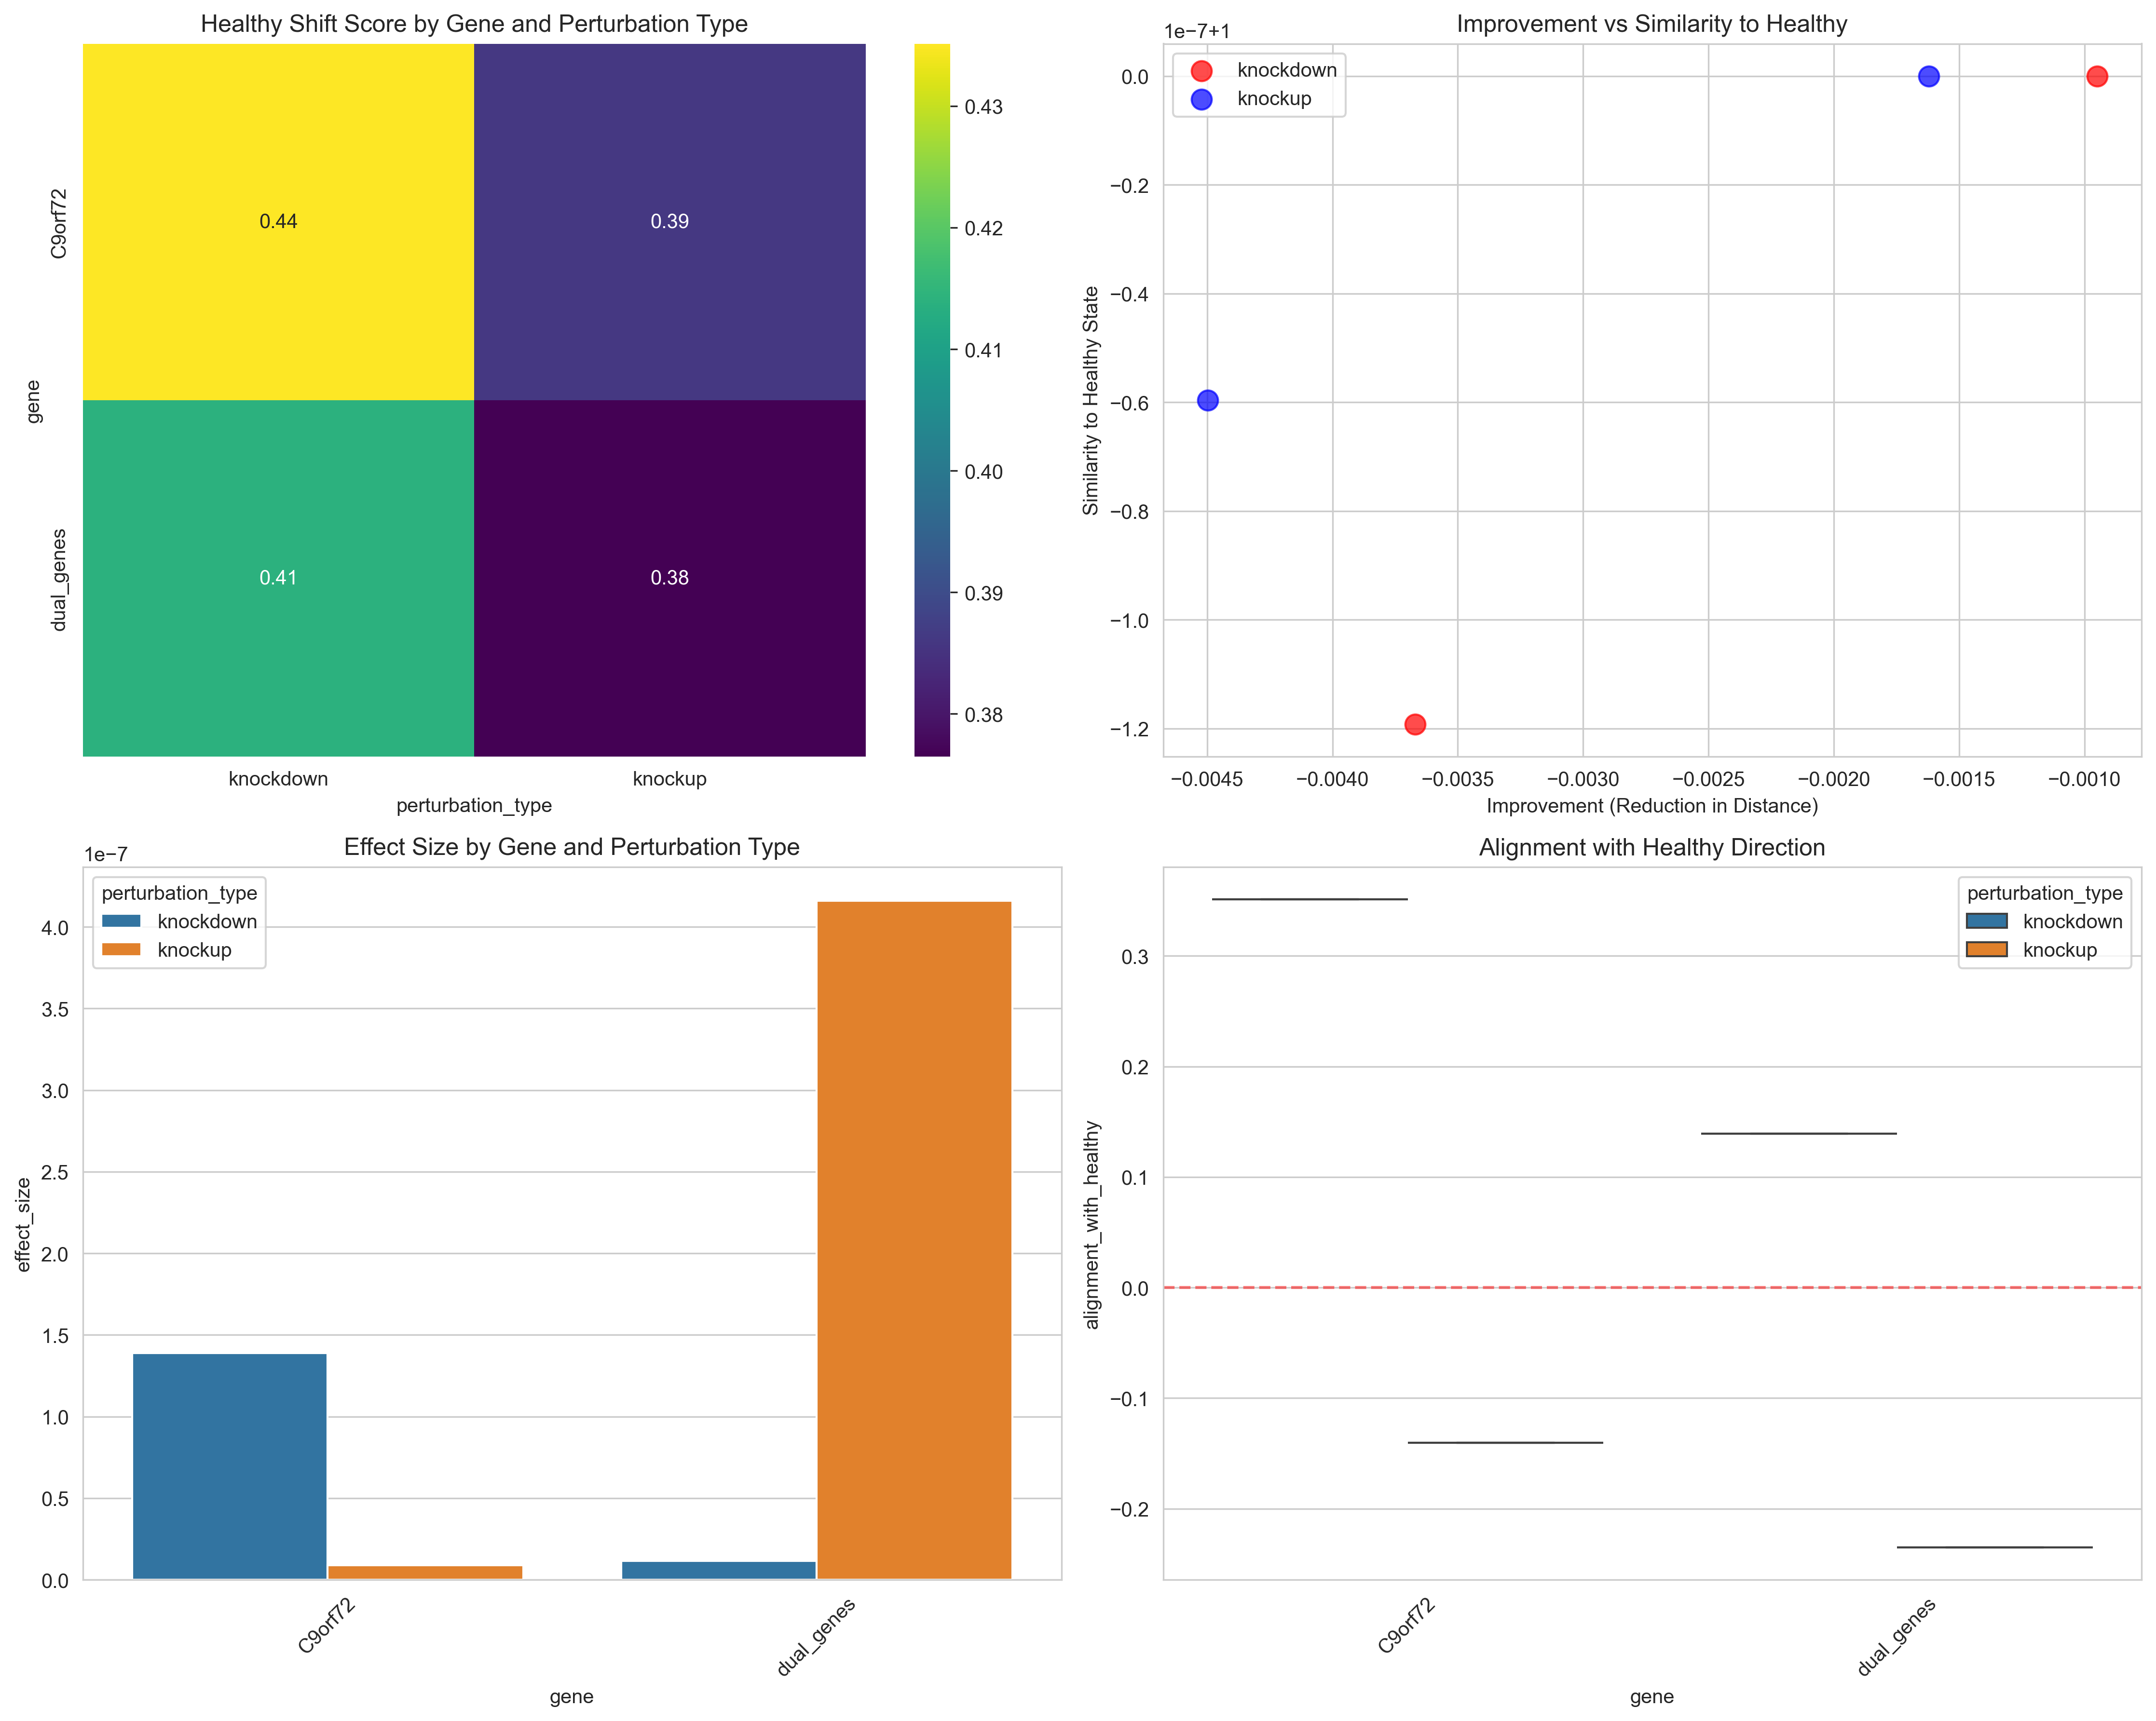

TOP GENE PERTURBATION RECOMMENDATIONS
For Shifting ALS Disease State Toward Healthy State

#1: C9orf72 - knockdown
   Condition: C9orf72_ALS_down
   Healthy Shift Score: 0.435
   Improvement: -0.0009
   Similarity to Healthy: 1.000
   Alignment: 0.351
   Effect Size: 0.000
   Interpretation: This perturbation moves the disease state moderately aligned with the healthy direction.

#2: dual_genes - knockdown
   Condition: dual_ALS_down
   Healthy Shift Score: 0.414
   Improvement: -0.0037
   Similarity to Healthy: 1.000
   Alignment: 0.139
   Effect Size: 0.000
   Interpretation: This perturbation moves the disease state moderately aligned with the healthy direction.

#3: C9orf72 - knockup
   Condition: C9orf72_ALS_up
   Healthy Shift Score: 0.386
   Improvement: -0.0016
   Similarity to Healthy: 1.000
   Alignment: -0.140
   Effect Size: 0.000
   Interpretation: This perturbation moves the disease state poorly aligned with the healthy direction.

#4: dual_genes - knockup
   Condition: d

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy import stats

def identify_healthy_shift_genes(combined_adata, base_embeddings, perturbation_embeddings_dict):
    """
    Identify genes that most effectively shift disease state toward healthy state
    """
    
    # Calculate healthy (base) centroid
    healthy_centroid = np.mean(base_embeddings, axis=0)
    
    # Calculate disease state centroid (average of all perturbation states)
    disease_states = []
    for condition, embeddings in perturbation_embeddings_dict.items():
        if condition != 'base':
            disease_states.append(embeddings)
    
    if disease_states:
        disease_centroid = np.mean(np.vstack(disease_states), axis=0)
    else:
        disease_centroid = healthy_centroid  # Fallback if no disease states
    
    results = []
    
    for condition, embeddings in perturbation_embeddings_dict.items():
        if condition == 'base':
            continue  # Skip base condition
            
        # Calculate perturbation centroid
        pert_centroid = np.mean(embeddings, axis=0)
        
        # Calculate distance from disease state to healthy state
        disease_to_healthy_dist = np.linalg.norm(disease_centroid - healthy_centroid)
        
        # Calculate distance from perturbation to healthy state
        pert_to_healthy_dist = np.linalg.norm(pert_centroid - healthy_centroid)
        
        # Calculate improvement (reduction in distance to healthy)
        improvement = disease_to_healthy_dist - pert_to_healthy_dist
        
        # Calculate cosine similarity with healthy state
        healthy_similarity = cosine_similarity(
            pert_centroid.reshape(1, -1), 
            healthy_centroid.reshape(1, -1)
        )[0][0]
        
        # Calculate movement direction (angle between vectors)
        disease_to_healthy_vector = healthy_centroid - disease_centroid
        disease_to_pert_vector = pert_centroid - disease_centroid
        
        if np.linalg.norm(disease_to_healthy_vector) > 0 and np.linalg.norm(disease_to_pert_vector) > 0:
            # Normalize vectors
            healthy_dir = disease_to_healthy_vector / np.linalg.norm(disease_to_healthy_vector)
            pert_dir = disease_to_pert_vector / np.linalg.norm(disease_to_pert_vector)
            
            # Calculate alignment with healthy direction
            alignment = np.dot(healthy_dir, pert_dir)
        else:
            alignment = 0
        
        # Calculate effect size (Cohen's d)
        healthy_embeddings_2d = PCA(n_components=2).fit_transform(base_embeddings)
        pert_embeddings_2d = PCA(n_components=2).fit_transform(embeddings)
        
        # Effect size on first principal component
        if len(healthy_embeddings_2d) > 1 and len(pert_embeddings_2d) > 1:
            cohens_d = (np.mean(pert_embeddings_2d[:, 0]) - np.mean(healthy_embeddings_2d[:, 0])) / \
                      np.sqrt((np.var(healthy_embeddings_2d[:, 0]) + np.var(pert_embeddings_2d[:, 0])) / 2)
        else:
            cohens_d = 0
        
        # Parse gene and perturbation type from condition name
        if 'C9orf72' in condition:
            gene = 'C9orf72'
            if 'down' in condition.lower():
                pert_type = 'knockdown'
            else:
                pert_type = 'knockup'
        elif 'dual' in condition.lower():
            gene = 'dual_genes'  # Assuming this targets multiple genes
            if 'down' in condition.lower():
                pert_type = 'knockdown'
            else:
                pert_type = 'knockup'
        else:
            gene = 'unknown'
            pert_type = 'unknown'
        
        results.append({
            'gene': gene,
            'perturbation_type': pert_type,
            'condition': condition,
            'distance_to_healthy': pert_to_healthy_dist,
            'improvement': improvement,
            'healthy_similarity': healthy_similarity,
            'alignment_with_healthy': alignment,
            'effect_size': abs(cohens_d),  # Absolute value for magnitude
            'healthy_shift_score': calculate_healthy_shift_score(
                improvement, healthy_similarity, alignment, abs(cohens_d)
            )
        })
    
    return pd.DataFrame(results)

def calculate_healthy_shift_score(improvement, similarity, alignment, effect_size):
    """
    Calculate composite score for healthy state shift effectiveness
    """
    # Normalize and weight different metrics
    # Higher improvement = better (moving toward healthy)
    # Higher similarity = better (more like healthy)
    # Higher alignment = better (moving in right direction)
    # Higher effect size = better (stronger effect)
    
    # Convert alignment from [-1, 1] to [0, 1] where 1 is perfect alignment
    alignment_score = (alignment + 1) / 2
    
    # Composite score (weights can be adjusted based on domain knowledge)
    score = (
        0.3 * min(max(improvement, 0), 1) +  # Improvement (capped at 1)
        0.3 * max(similarity, 0) +           # Similarity to healthy
        0.2 * alignment_score +              # Direction alignment
        0.2 * min(effect_size / 2, 1)        # Effect size (normalized)
    )
    
    return score

def analyze_gene_effectiveness(combined_adata):
    """
    Comprehensive analysis of gene perturbation effectiveness
    """
    
    # Extract embeddings for each condition
    conditions = combined_adata.obs['Condition'].unique()
    embeddings_dict = {}
    
    for condition in conditions:
        mask = combined_adata.obs['Condition'] == condition
        embeddings_dict[condition] = combined_adata[mask].obsm['GF']
    
    # Identify healthy shift genes
    results_df = identify_healthy_shift_genes(
        combined_adata, 
        embeddings_dict['base'], 
        {k: v for k, v in embeddings_dict.items() if k != 'base'}
    )
    
    # Rank by healthy shift score
    results_df = results_df.sort_values('healthy_shift_score', ascending=False)
    
    return results_df

def visualize_gene_effectiveness(results_df):
    """
    Create visualizations for gene effectiveness analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Healthy shift score by gene and perturbation type
    pivot_data = results_df.pivot_table(
        index='gene', 
        columns='perturbation_type', 
        values='healthy_shift_score',
        aggfunc='mean'
    ).fillna(0)
    
    sns.heatmap(pivot_data, annot=True, cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Healthy Shift Score by Gene and Perturbation Type')
    
    # 2. Improvement vs Similarity scatter plot
    colors = {'knockdown': 'red', 'knockup': 'blue'}
    for pert_type in results_df['perturbation_type'].unique():
        mask = results_df['perturbation_type'] == pert_type
        axes[0,1].scatter(
            results_df.loc[mask, 'improvement'],
            results_df.loc[mask, 'healthy_similarity'],
            c=colors[pert_type],
            label=pert_type,
            s=100,
            alpha=0.7
        )
    
    axes[0,1].set_xlabel('Improvement (Reduction in Distance)')
    axes[0,1].set_ylabel('Similarity to Healthy State')
    axes[0,1].legend()
    axes[0,1].set_title('Improvement vs Similarity to Healthy')
    
    # 3. Effect size comparison
    sns.barplot(data=results_df, x='gene', y='effect_size', 
                hue='perturbation_type', ax=axes[1,0])
    axes[1,0].set_title('Effect Size by Gene and Perturbation Type')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Alignment with healthy direction
    sns.boxplot(data=results_df, x='gene', y='alignment_with_healthy', 
                hue='perturbation_type', ax=axes[1,1])
    axes[1,1].set_title('Alignment with Healthy Direction')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('gene_effectiveness_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_recommendations(results_df, top_n=5):
    """
    Generate specific recommendations based on analysis
    """
    print("="*60)
    print("TOP GENE PERTURBATION RECOMMENDATIONS")
    print("For Shifting ALS Disease State Toward Healthy State")
    print("="*60)
    
    top_recommendations = results_df.head(top_n)
    
    for i, (idx, row) in enumerate(top_recommendations.iterrows(), 1):
        print(f"\n#{i}: {row['gene']} - {row['perturbation_type']}")
        print(f"   Condition: {row['condition']}")
        print(f"   Healthy Shift Score: {row['healthy_shift_score']:.3f}")
        print(f"   Improvement: {row['improvement']:.4f}")
        print(f"   Similarity to Healthy: {row['healthy_similarity']:.3f}")
        print(f"   Alignment: {row['alignment_with_healthy']:.3f}")
        print(f"   Effect Size: {row['effect_size']:.3f}")
        
        # Interpretation
        if row['alignment_with_healthy'] > 0.5:
            direction = "strongly aligned"
        elif row['alignment_with_healthy'] > 0:
            direction = "moderately aligned"
        else:
            direction = "poorly aligned"
            
        print(f"   Interpretation: This perturbation moves the disease state {direction} with the healthy direction.")
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    by_gene = results_df.groupby('gene').agg({
        'healthy_shift_score': ['mean', 'max'],
        'improvement': 'mean',
        'healthy_similarity': 'mean'
    }).round(3)
    
    print("\nAverage performance by gene:")
    print(by_gene)
    
    # Best perturbation type overall
    by_pert_type = results_df.groupby('perturbation_type')['healthy_shift_score'].mean()
    best_overall_type = by_pert_type.idxmax()
    
    print(f"\nOverall, {best_overall_type} perturbations show better results.")
    
    return top_recommendations

# Main analysis function
def main_gene_analysis():
    """
    Main function to analyze gene perturbation effectiveness
    """
    print("Analyzing gene perturbation effectiveness...")
    
    # Assuming combined_adata is available from previous analysis
    # If not, we need to reload the data
    try:
        combined_adata
    except NameError:
        print("Loading data...")
        # Reload your data here if needed
        # combined_adata = ad.read_h5ad('combined_perturbation_analysis.h5ad')
        return
    
    # Analyze gene effectiveness
    results_df = analyze_gene_effectiveness(combined_adata)
    
    # Visualize results
    visualize_gene_effectiveness(results_df)
    
    # Generate recommendations
    top_genes = generate_recommendations(results_df)
    
    # Save results
    results_df.to_csv('gene_perturbation_effectiveness_ranking.csv', index=False)
    
    print(f"\nAnalysis complete! Results saved to:")
    print("- gene_perturbation_effectiveness_ranking.csv")
    print("- gene_effectiveness_analysis.png")
    
    return results_df, top_genes

# Additional analysis: Pathway-level insights
def pathway_level_analysis(results_df):
    """
    Provide biological interpretation at pathway level
    """
    print("\n" + "="*60)
    print("PATHWAY-LEVEL INTERPRETATION")
    print("="*60)
    
    # Known ALS pathways and genes (simplified)
    als_pathways = {
        'C9orf72': {
            'pathways': ['RNA processing', 'Nucleocytoplasmic transport', 'Autophagy'],
            'mechanism': 'Hexanucleotide repeat expansion causes gain-of-function toxicity',
            'therapeutic_approach': 'Reduce toxic repeat RNA or dipeptide proteins'
        },
        'dual_genes': {
            'pathways': ['Multiple pathways', 'Protein homeostasis', 'Axonal transport'],
            'mechanism': 'Combined targeting of key ALS mechanisms',
            'therapeutic_approach': 'Multi-target intervention for synergistic effects'
        }
    }
    
    for gene in results_df['gene'].unique():
        if gene in als_pathways:
            gene_data = als_pathways[gene]
            gene_results = results_df[results_df['gene'] == gene]
            
            print(f"\n{gene} - Biological Context:")
            print(f"  Involved in: {', '.join(gene_data['pathways'])}")
            print(f"  ALS mechanism: {gene_data['mechanism']}")
            print(f"  Therapeutic approach: {gene_data['therapeutic_approach']}")
            
            # Best perturbation type for this gene
            best_pert = gene_results.loc[gene_results['healthy_shift_score'].idxmax()]
            print(f"  Most effective: {best_pert['perturbation_type']} " 
                  f"(Score: {best_pert['healthy_shift_score']:.3f})")
            
            # Interpretation
            if best_pert['perturbation_type'] == 'knockdown':
                print("  → Suggests reducing gene expression may alleviate toxicity")
            else:
                print("  → Suggests enhancing gene function may be protective")

# Execute the analysis
if __name__ == "__main__":
    results_df, top_genes = main_gene_analysis()
    pathway_level_analysis(results_df)